# Домашнее задание 3

## 0. Введение

Проблемой короновируса COVID-19 буквально сейчас заняты многие ученые по всему миру. В стороне не осталось и комьюнити Data scientist-ов, которые пытаются не просто предсказать развитие пандемии, а помочь определить наиболее значимые факторы, влияющие на распространение заразы. Например на небезызвестном [Kaggle](https://www.kaggle.com/tags/covid19).

В данной домашней работе Вы будете использовать ежедневно обновляемые данные из [репозитория](https://github.com/datasets/covid-19), а конкретно [time-series-19-covid-combined.csv](https://github.com/datasets/covid-19/blob/master/data/time-series-19-covid-combined.csv).

Вам предстоит изучить имеющиеся данные, попробовать найти некоторые закономерности и ответить на вопросы. Ниже представлены задания как исследовательского характера, где приветствуется инициативность, так и чисто тренировочного харатера - где необходимо использовать изученные на семинаре инструменты для работы с временными рядами. **Не забывайте сопровождать ваш код развернутыми комментариями и выводами.** Чем их больше и чем они качественнее, тем лучше и выше вероятность получения максимальной оценки за домашнее задание. Не болейте!

In [1]:
!wget -O covid.csv https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv --no-check-certificate -q

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

In [200]:
df = pd.read_csv('covid.csv', parse_dates=['Date'])
df.head()

Date Country/Region Province/State   Lat  Long  Confirmed  Recovered  \
0 2020-01-22    Afghanistan            NaN 33.00 65.00       0.00       0.00   
1 2020-01-23    Afghanistan            NaN 33.00 65.00       0.00       0.00   
2 2020-01-24    Afghanistan            NaN 33.00 65.00       0.00       0.00   
3 2020-01-25    Afghanistan            NaN 33.00 65.00       0.00       0.00   
4 2020-01-26    Afghanistan            NaN 33.00 65.00       0.00       0.00   

   Deaths  
0    0.00  
1    0.00  
2    0.00  
3    0.00  
4    0.00

## 1. Exploratory data analysis

#### 1.1 Определите границы исследуемого периода, количество заболевших, погибших, выздоровивших. Отобразите на карте распространение болезни.

 Границы исследования

In [201]:
df['Date'].agg(['min', 'max'])

min   2020-01-22
max   2020-04-28
Name: Date, dtype: datetime64[ns]

Количество заболевших, выздоровивших и погибших

In [202]:
df[df['Date'] == df['Date'].max()][['Confirmed', 'Recovered', 'Deaths']].sum()

Confirmed   3116398.00
Recovered    928658.00
Deaths       217153.00
dtype: float64

Карта

Данные логарифмированы, иначе будет одна яркая точка -- США.
На карте доступна анимация, а так же масштабирвоание.

In [5]:
import folium
import folium.plugins as plugins

In [6]:
data = []
__df = df[(~df['Confirmed'].isna()) & (df['Province/State'] != 'Diamond Princess')].copy()
__df['Confirmed'] = np.log(1 + __df['Confirmed'])
__df['Confirmed'] =  __df['Confirmed'] / __df['Confirmed'].max()
__df = __df[['Date', 'Lat', 'Long', 'Confirmed']].groupby('Date').agg(lambda x: list(x))
for date, row in __df.iterrows():
    row  = list(zip(*row))
    row = [[x[0], x[1], np.clip(x[2], 0.00001, 1)] for x in row if x[2] > 0]
    data.append(row)
    
m = folium.Map([0., 0.], zoom_start=2)

hm = plugins.HeatMapWithTime(data, 
                             index=list(__df.index.strftime('%Y-%m-%d').values),
                             auto_play=True,
                             min_speed=1,
                            )

hm.add_to(m)
m

#### 1.2 Определите количество стран, которые подтвердили случаи заражения. Визуализируйте рост количества стран, подтвердивших случаи заражения по дням (или неделям). 

  *Примечание. В анализе временных рядов иногда необходимо изменить частоту дискретизации (Resampling). Такая операция может понадобится, когда имеющихся данных недостаточно или их, наоборот, слишком много. Может не устраивать имеющаяся частота или просто хочется посмотреть на данные с более общего ракурса.*

  *Различают два вида изменения частоты: повышение (Upsampling) и понижение (Downsampling). При повышении временной ряд пересчитывается с низкой частоы на более высокую частоту (например от годовой до месячной частоты). В таком случае процесс включает в себя заполнение или интерполяцию появившихся пропусков в данных. При понижении временной ряд передискретизируется с высокой частоты на низкую (наример с еженедельной на месячную частоту). Это включает в себя агрегацию существующих данных.*

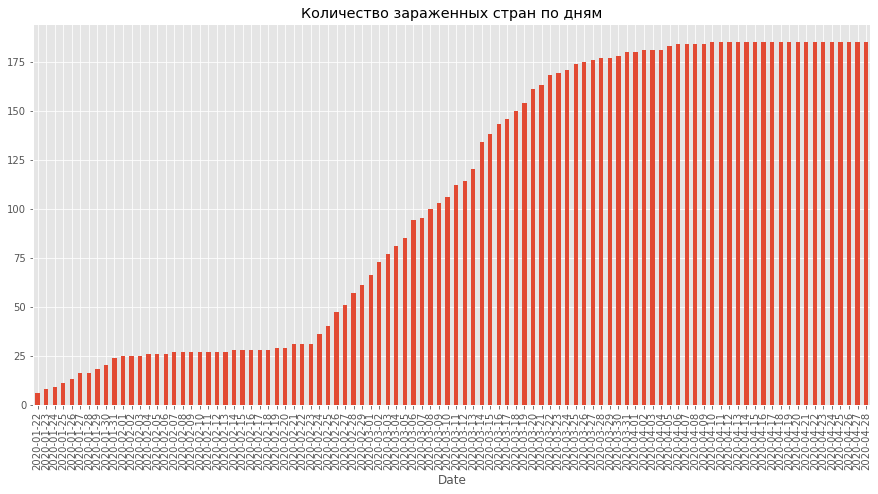

In [203]:
data = df[df['Confirmed'] > 0].groupby('Date')['Country/Region'].nunique()
data.name = 'Approved countries'
data.index = data.index.strftime('%Y-%m-%d')
data.plot.bar(figsize=(15, 7), title='Количество зараженных стран по дням');

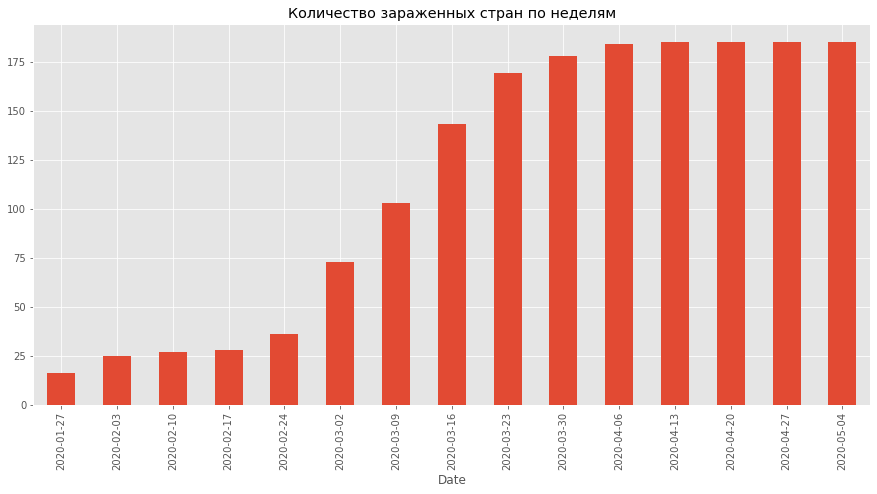

In [8]:
data = df[df['Confirmed'] > 0].groupby(pd.Grouper(key='Date', freq='W-MON'))['Country/Region'].nunique()
data.name = 'Approved countries'
data.index = data.index.strftime('%Y-%m-%d')
data.plot.bar(figsize=(15, 7), title='Количество зараженных стран по неделям');

#### 1.3 Визуализируйте мировые тренды по числу заболевших | погибших | выздоровивших. Постройте графики, которые отражают летальность от вируса в разных странах или на разных континентах. 

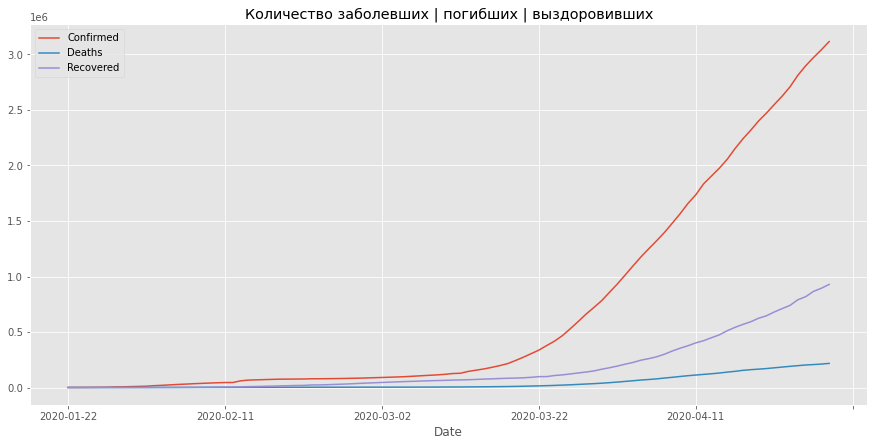

In [9]:
data = df.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum()
data.index = data.index.strftime('%Y-%m-%d')
data.plot(figsize=(15, 7), title='Количество заболевших | погибших | выздоровивших');

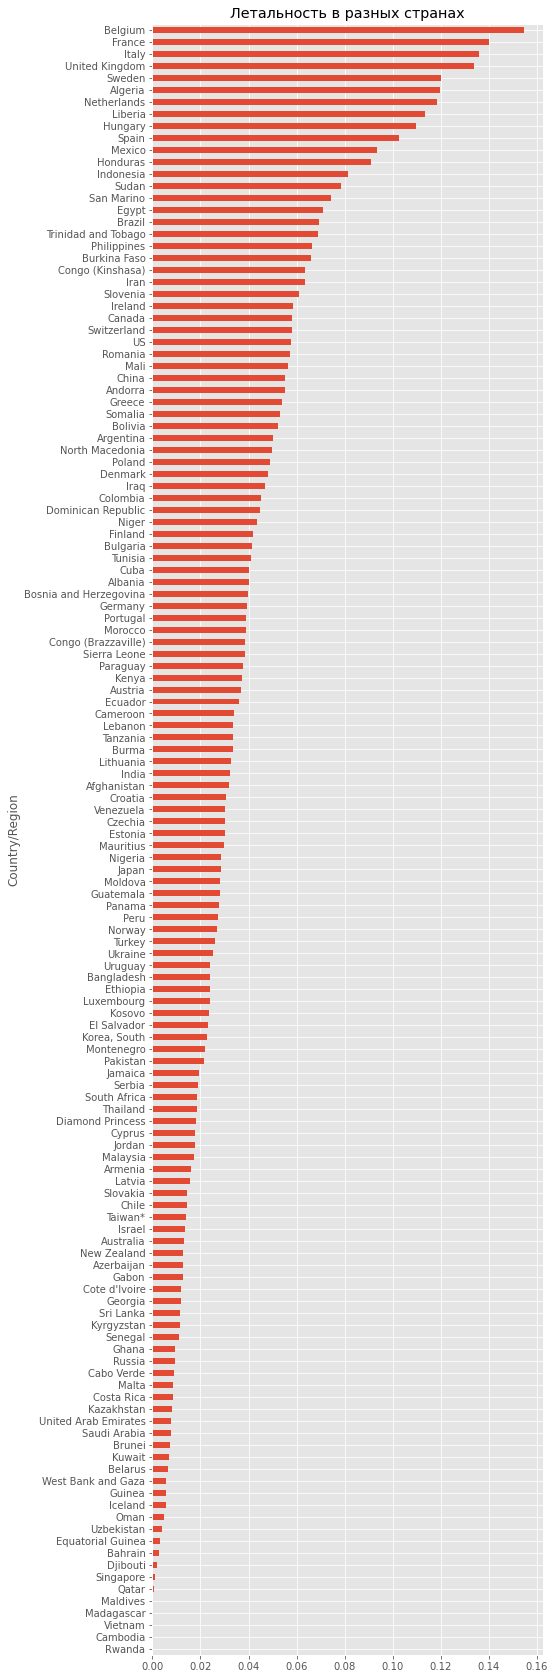

In [10]:
__df = df[(df['Date'] == df['Date'].max()) & (df['Confirmed'] > 0)].copy()
__df = __df.groupby('Country/Region')[['Deaths', 'Confirmed']].sum()
__df['cfr'] = __df['Deaths'] / __df['Confirmed']
__df.sort_values('cfr', inplace=True)
__df = __df[__df['Confirmed'] > 100]
# __df = __df[__df['cfr'] > __df['cfr'].mean()]
__df['cfr'].plot.barh(figsize=(7, 30), title='Летальность в разных странах');

#### 1.4 Визуализируйте и сравните, как распространялась болезнь в разных странах или континентах по дням с первого зарегистрированного случая заболевания. Определите количество дней для каждой страны со дня первого зарегестрированного случая.

Подчистим данные

In [205]:
df_c = df.groupby(['Date', 'Country/Region'])[['Confirmed', 'Recovered', 'Deaths']].sum().reset_index()
df_c

Date      Country/Region  Confirmed  Recovered  Deaths
0     2020-01-22         Afghanistan       0.00       0.00    0.00
1     2020-01-22             Albania       0.00       0.00    0.00
2     2020-01-22             Algeria       0.00       0.00    0.00
3     2020-01-22             Andorra       0.00       0.00    0.00
4     2020-01-22              Angola       0.00       0.00    0.00
...          ...                 ...        ...        ...     ...
18125 2020-04-28  West Bank and Gaza     343.00      71.00    2.00
18126 2020-04-28      Western Sahara       6.00       5.00    0.00
18127 2020-04-28               Yemen       1.00       1.00    0.00
18128 2020-04-28              Zambia      95.00      42.00    3.00
18129 2020-04-28            Zimbabwe      32.00       5.00    4.00

[18130 rows x 5 columns]

In [206]:
region_start = df_c[df_c['Confirmed'] > 0].groupby('Country/Region')['Date'].min()
region_start.name = 'd_start'
__df = pd.merge(df_c[df_c['Confirmed'] > 0], region_start, on='Country/Region')
__df['n_day'] = (__df['Date'] - __df['d_start']).dt.days
__df['Active'] = __df['Confirmed'] - __df['Recovered'] - __df['Deaths']
__df

Date Country/Region  Confirmed  Recovered  Deaths    d_start  \
0     2020-01-22          China     548.00      28.00   17.00 2020-01-22   
1     2020-01-23          China     643.00      30.00   18.00 2020-01-22   
2     2020-01-24          China     920.00      36.00   26.00 2020-01-22   
3     2020-01-25          China    1406.00      39.00   42.00 2020-01-22   
4     2020-01-26          China    2075.00      49.00   56.00 2020-01-22   
...          ...            ...        ...        ...     ...        ...   
10378 2020-04-24          Yemen       1.00       1.00    0.00 2020-04-10   
10379 2020-04-25          Yemen       1.00       1.00    0.00 2020-04-10   
10380 2020-04-26          Yemen       1.00       1.00    0.00 2020-04-10   
10381 2020-04-27          Yemen       1.00       1.00    0.00 2020-04-10   
10382 2020-04-28          Yemen       1.00       1.00    0.00 2020-04-10   

       n_day  Active  
0          0  503.00  
1          1  595.00  
2          2  858.00  
3          3 1325.00  
4          4 1970.00  
...      ...     ...  
10378     14    0.00  
10379     15    0.00  
10380     16    0.00  
10381     17    0.00  
10382     18    0.00  

[10383 rows x 8 columns]

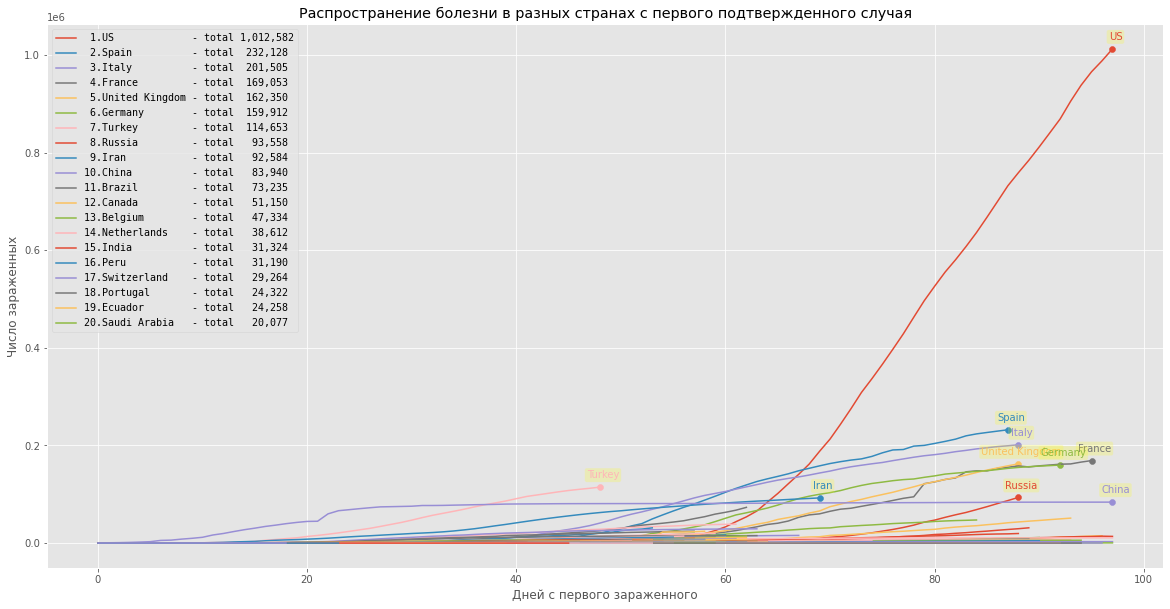

In [207]:
plt.figure(figsize=(20,10), facecolor='w')
for i, (name, row) in enumerate(( __df
                                 .groupby('Country/Region')[['Confirmed', 'n_day']]
                                 .agg(lambda x: list(x))
                                 .join(
                                     __df.groupby('Country/Region')['Confirmed']
                                    .max()
                                    .astype(np.int32),
                                     rsuffix='_max')
                                 .sort_values('Confirmed_max', ascending=False)
                                ).iterrows()):
    color = plt.plot(row['n_day'], row['Confirmed'], label=f'{i+1:>2}.{name:<15}- total {row["Confirmed_max"]:>8,d}' if i < 20 else None)[0].get_color()
    if i < 10:
        plt.scatter(row['n_day'][-1], row['Confirmed'][-1], color=color, alpha=1)
        plt.annotate(f'{name}', (row['n_day'][-1], row['Confirmed'][-1]),
                     xytext=(3, 7), textcoords='offset points', ha='center', va='bottom', color=color,
                     bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.2))
plt.legend(prop={'family': 'monospace'})
plt.xlabel('Дней с первого зараженного')
plt.ylabel('Число зараженных')
plt.title('Распространение болезни в разных странах с первого подтвержденного случая');

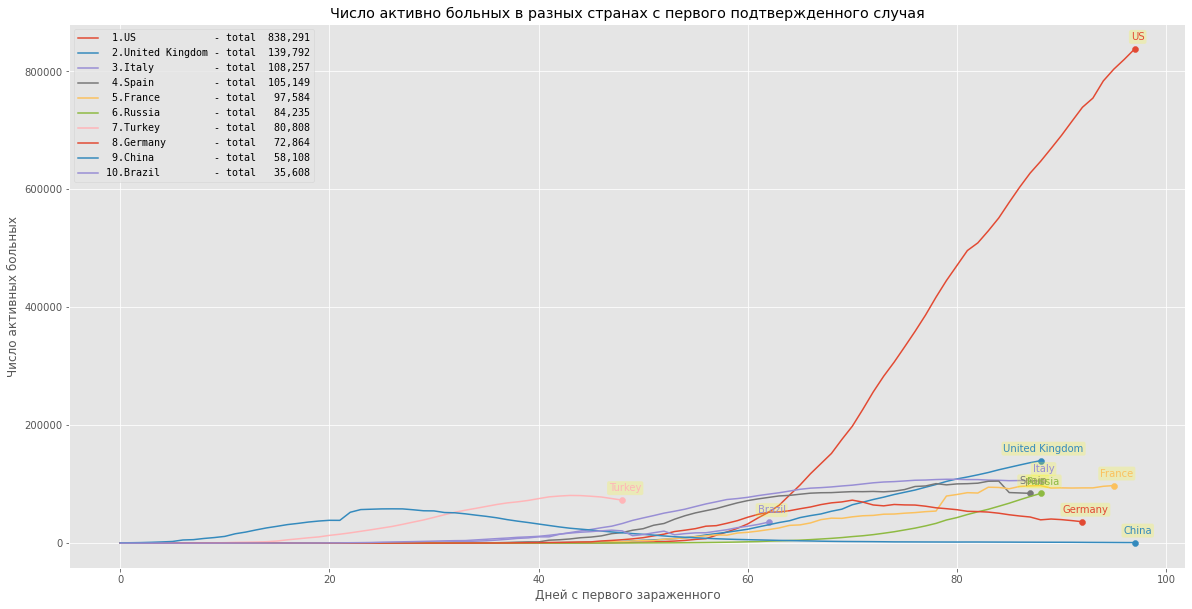

In [208]:
plt.figure(figsize=(20,10), facecolor='w')
for i, (name, row) in enumerate(( __df
                                 .groupby('Country/Region')[['Active', 'n_day']]
                                 .agg(lambda x: list(x))
                                 .join(
                                     __df.groupby('Country/Region')['Active']
                                    .max()
                                    .astype(np.int32),
                                     rsuffix='_max')
                                 .sort_values('Active_max', ascending=False)
                                ).iterrows()):
    if i < 10:
        color = plt.plot(row['n_day'], row['Active'], label=f'{i+1:>2}.{name:<15}- total {row["Active_max"]:>8,d}' if i < 20 else None)[0].get_color()
        plt.scatter(row['n_day'][-1], row['Active'][-1], color=color, alpha=1)
        plt.annotate(f'{name}', (row['n_day'][-1], row['Active'][-1]),
                     xytext=(3, 7), textcoords='offset points', ha='center', va='bottom', color=color,
                     bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.2))
plt.legend(prop={'family': 'monospace'})
plt.xlabel('Дней с первого зараженного')
plt.ylabel('Число активных больных')
plt.title('Число активно больных в разных странах с первого подтвержденного случая');

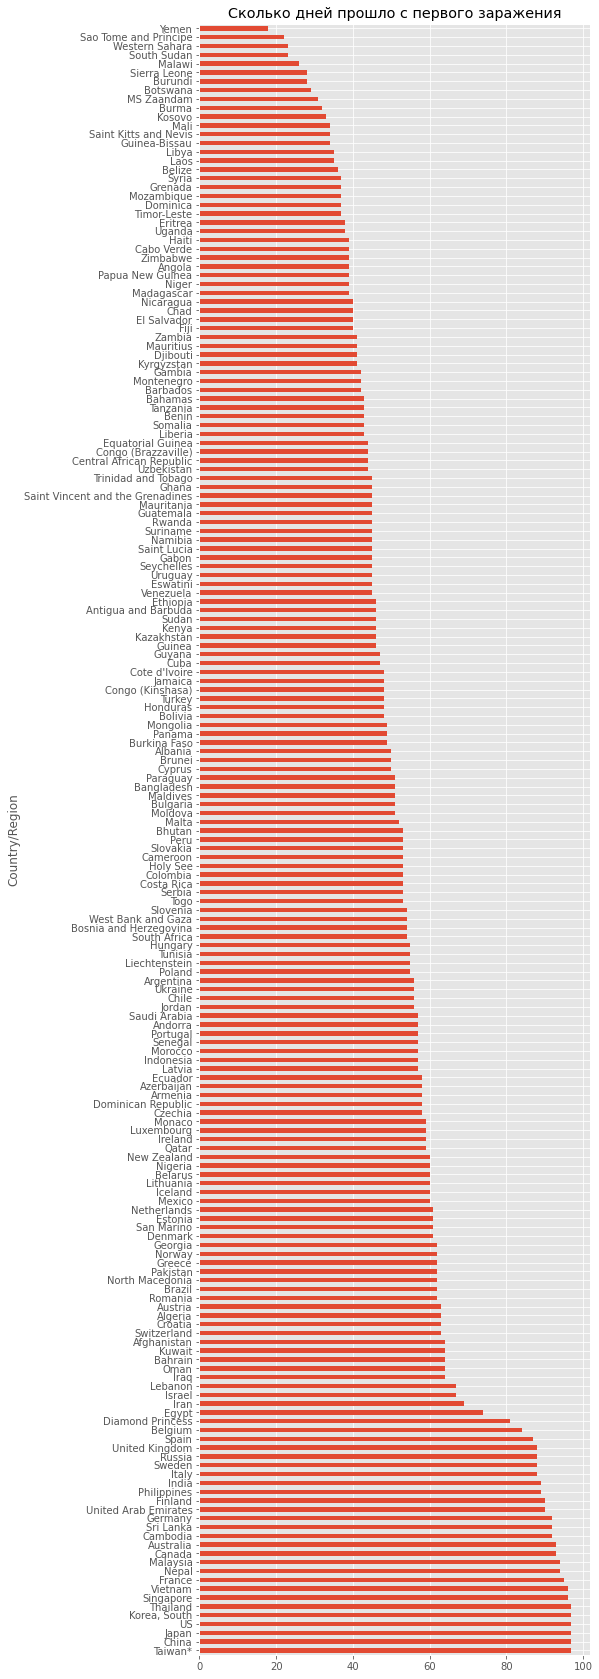

In [209]:
(
    __df
    .groupby('Country/Region')['n_day']
    .max()
    .sort_values(ascending=False)
    .plot
    .barh(figsize=(7, 30), title='Сколько дней прошло с первого заражения')
);

# Построим (для интереса) аналогичные графики от 100 зараженного

In [16]:
region_start_100 = df_c[df_c['Confirmed'] >= 100].groupby('Country/Region')['Date'].min()
region_start_100.name = 'd_start100'
__df = pd.merge(df_c[df_c['Confirmed'] >= 100], region_start_100, on='Country/Region')
__df['n_day'] = (__df['Date'] - __df['d_start100']).dt.days
__df['Active'] = __df['Confirmed'] - __df['Recovered'] - __df['Deaths']
__df

Date     Country/Region  Confirmed  Recovered  Deaths d_start100  \
0    2020-01-22              China     548.00      28.00   17.00 2020-01-22   
1    2020-01-23              China     643.00      30.00   18.00 2020-01-22   
2    2020-01-24              China     920.00      36.00   26.00 2020-01-22   
3    2020-01-25              China    1406.00      39.00   42.00 2020-01-22   
4    2020-01-26              China    2075.00      49.00   56.00 2020-01-22   
...         ...                ...        ...        ...     ...        ...   
5201 2020-04-28  Equatorial Guinea     315.00       9.00    1.00 2020-04-24   
5202 2020-04-26         Cabo Verde     106.00       1.00    1.00 2020-04-26   
5203 2020-04-27         Cabo Verde     109.00       1.00    1.00 2020-04-26   
5204 2020-04-28         Cabo Verde     114.00       2.00    1.00 2020-04-26   
5205 2020-04-28       Sierra Leone     104.00      12.00    4.00 2020-04-28   

      n_day  Active  
0         0  503.00  
1         1  595.00  
2         2  858.00  
3         3 1325.00  
4         4 1970.00  
...     ...     ...  
5201      4  305.00  
5202      0  104.00  
5203      1  107.00  
5204      2  111.00  
5205      0   88.00  

[5206 rows x 8 columns]

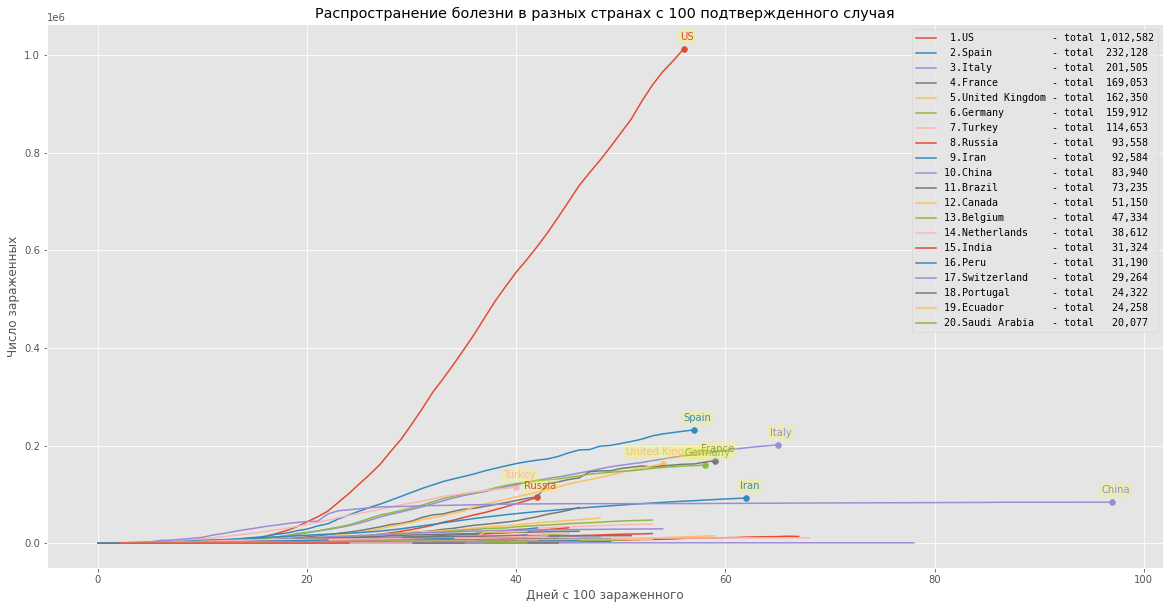

In [18]:
plt.figure(figsize=(20,10), facecolor='w')
for i, (name, row) in enumerate(( __df
                                 .groupby('Country/Region')[['Confirmed', 'n_day']]
                                 .agg(lambda x: list(x))
                                 .join(
                                     __df.groupby('Country/Region')['Confirmed']
                                    .max()
                                    .astype(np.int32),
                                     rsuffix='_max')
                                 .sort_values('Confirmed_max', ascending=False)
                                ).iterrows()):
    color = plt.plot(row['n_day'], row['Confirmed'], label=f'{i+1:>2}.{name:<15}- total {row["Confirmed_max"]:>8,d}' if i < 20 else None)[0].get_color()
    if i < 10:
        plt.scatter(row['n_day'][-1], row['Confirmed'][-1], color=color, alpha=1)
        plt.annotate(f'{name}', (row['n_day'][-1], row['Confirmed'][-1]),
                     xytext=(3, 7), textcoords='offset points', ha='center', va='bottom', color=color,
                     bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.2))
plt.legend(prop={'family': 'monospace'})
plt.xlabel('Дней с 100 зараженного')
plt.ylabel('Число зараженных')
plt.title('Распространение болезни в разных странах с 100 подтвержденного случая');

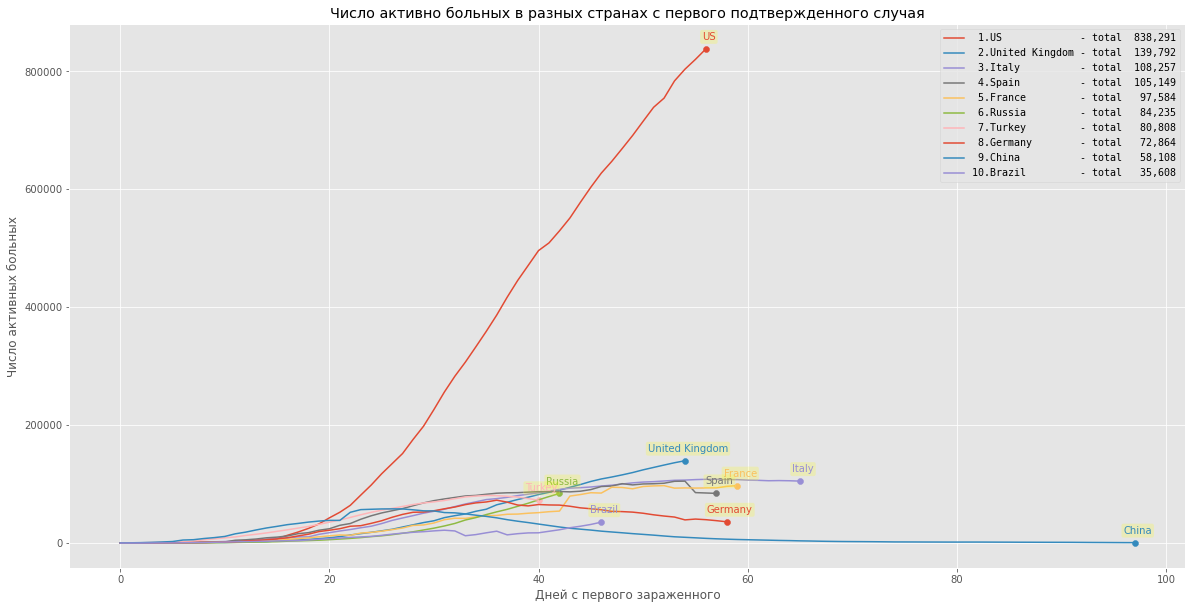

In [19]:
plt.figure(figsize=(20,10), facecolor='w')
for i, (name, row) in enumerate(( __df
                                 .groupby('Country/Region')[['Active', 'n_day']]
                                 .agg(lambda x: list(x))
                                 .join(
                                     __df.groupby('Country/Region')['Active']
                                    .max()
                                    .astype(np.int32),
                                     rsuffix='_max')
                                 .sort_values('Active_max', ascending=False)
                                ).iterrows()):
    if i < 10:
        color = plt.plot(row['n_day'], row['Active'], label=f'{i+1:>2}.{name:<15}- total {row["Active_max"]:>8,d}' if i < 20 else None)[0].get_color()
        plt.scatter(row['n_day'][-1], row['Active'][-1], color=color, alpha=1)
        plt.annotate(f'{name}', (row['n_day'][-1], row['Active'][-1]),
                     xytext=(3, 7), textcoords='offset points', ha='center', va='bottom', color=color,
                     bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.2))
plt.legend(prop={'family': 'monospace'})
plt.xlabel('Дней с первого зараженного')
plt.ylabel('Число активных больных')
plt.title('Число активно больных в разных странах с первого подтвержденного случая');

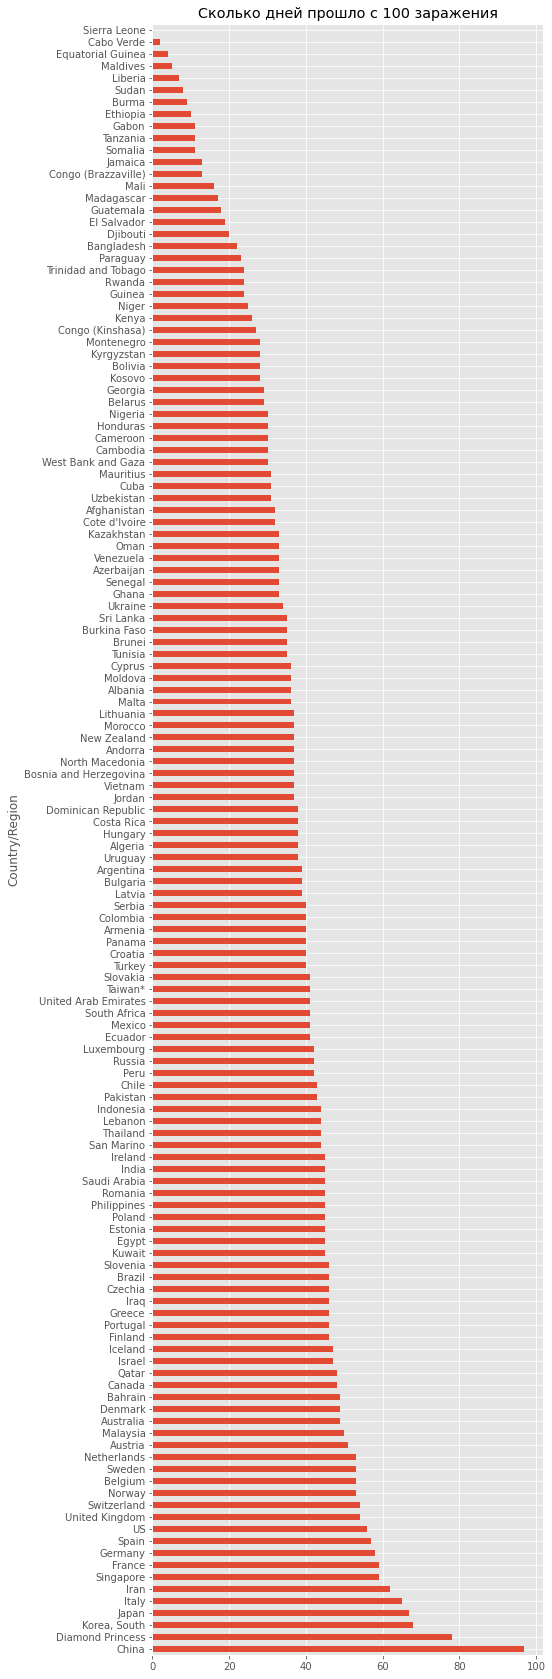

In [20]:
(
    __df
    .groupby('Country/Region')['n_day']
    .max()
    .sort_values(ascending=False)
    .plot
    .barh(figsize=(7, 30), title='Сколько дней прошло с 100 заражения')
);

Особой разницы между графиками не заметно, но от 100 зараженного выглядит более гладким

Если смотреть на Китай и Германию, то на переход от начала заражения до пика проходит меньше времени, чем от пика до спада.

#### 1.5 Визуализируйте и оцените как развивалась ситуация в России по сравнению с остальными миром.

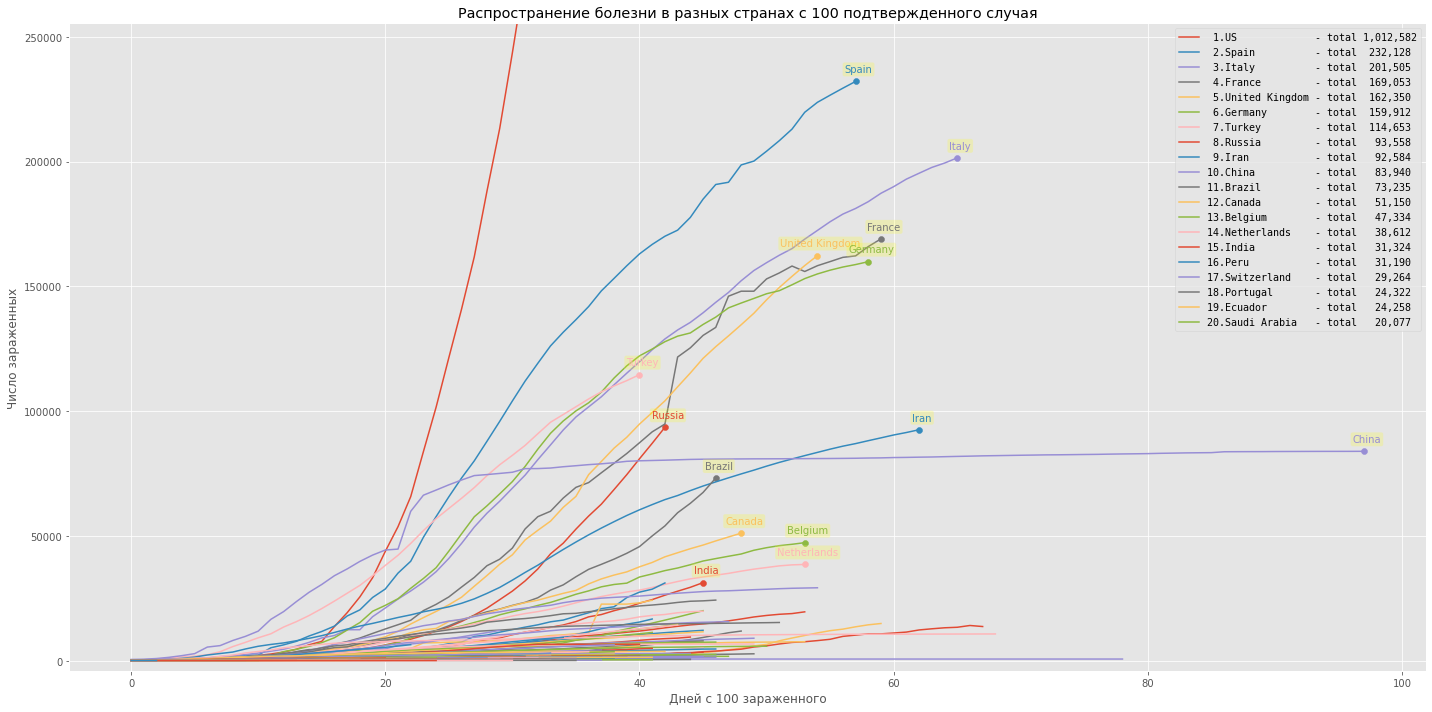

In [21]:
plt.figure(figsize=(20,10), facecolor='w')
for i, (name, row) in enumerate(( __df
                                 .groupby('Country/Region')[['Confirmed', 'n_day']]
                                 .agg(lambda x: list(x))
                                 .join(
                                     __df.groupby('Country/Region')['Confirmed']
                                    .max()
                                    .astype(np.int32),
                                     rsuffix='_max')
                                 .sort_values('Confirmed_max', ascending=False)
                                ).iterrows()):
    color = plt.plot(row['n_day'], row['Confirmed'], label=f'{i+1:>2}.{name:<15}- total {row["Confirmed_max"]:>8,d}' if i < 20 else None)[0].get_color()
    if 1 <= i < 15:
        plt.scatter(row['n_day'][-1], row['Confirmed'][-1], color=color, alpha=1)
        plt.annotate(f'{name}', (row['n_day'][-1], row['Confirmed'][-1]),
                     xytext=(3, 7), textcoords='offset points', ha='center', va='bottom', color=color,
                     bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.2))
plt.legend(prop={'family': 'monospace'})
plt.xlabel('Дней с 100 зараженного')
plt.ylabel('Число зараженных')
plt.ylim([-4000, 1.1 * __df.groupby('Country/Region')['Confirmed'].max().sort_values()[-2]])
plt.title('Распространение болезни в разных странах с 100 подтвержденного случая');
plt.tight_layout()

### Данные на 2020-04-23

Количество подтвержденных случаев в России близко к аналогичным в Бразилии, Канаде, Китаю и Ирану.

Если сравнивать темпы роста, то Россия похожа на UK, Францию, Италию, Германию.

По предыдущим графикам, у России еще все впереди.

#### 1.6 Определите топ-10 стран, которые лидируют по имеющимся в датасете показателям. Сравните насколько быстро развивается ситуация в этих странах, определите корреляцию.

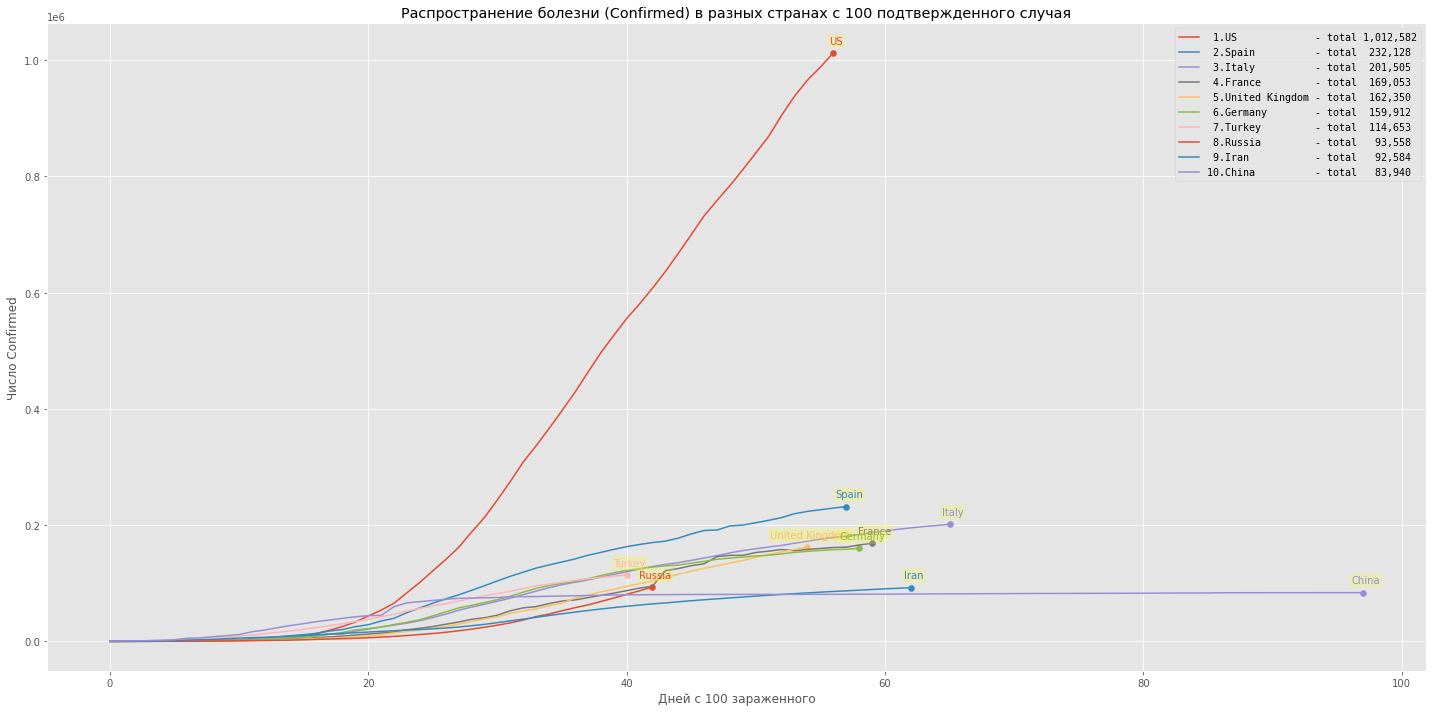

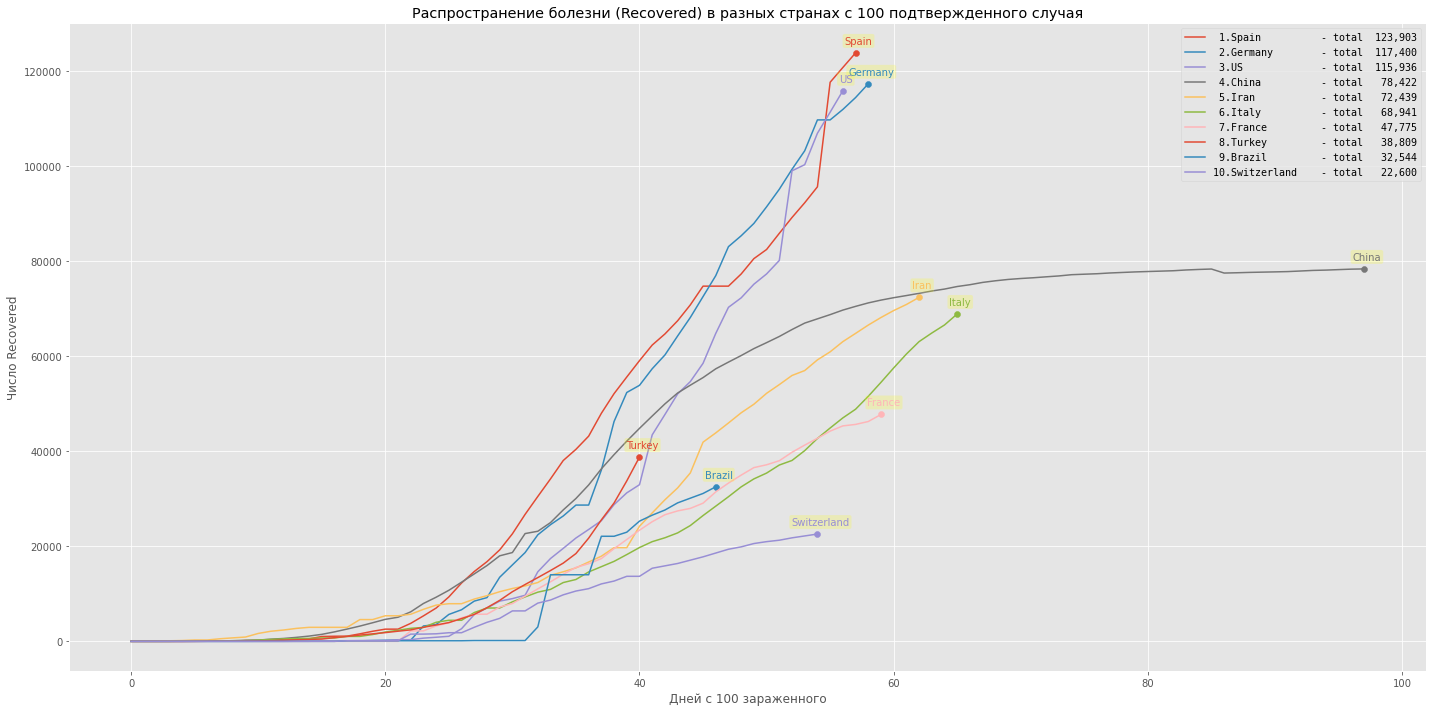

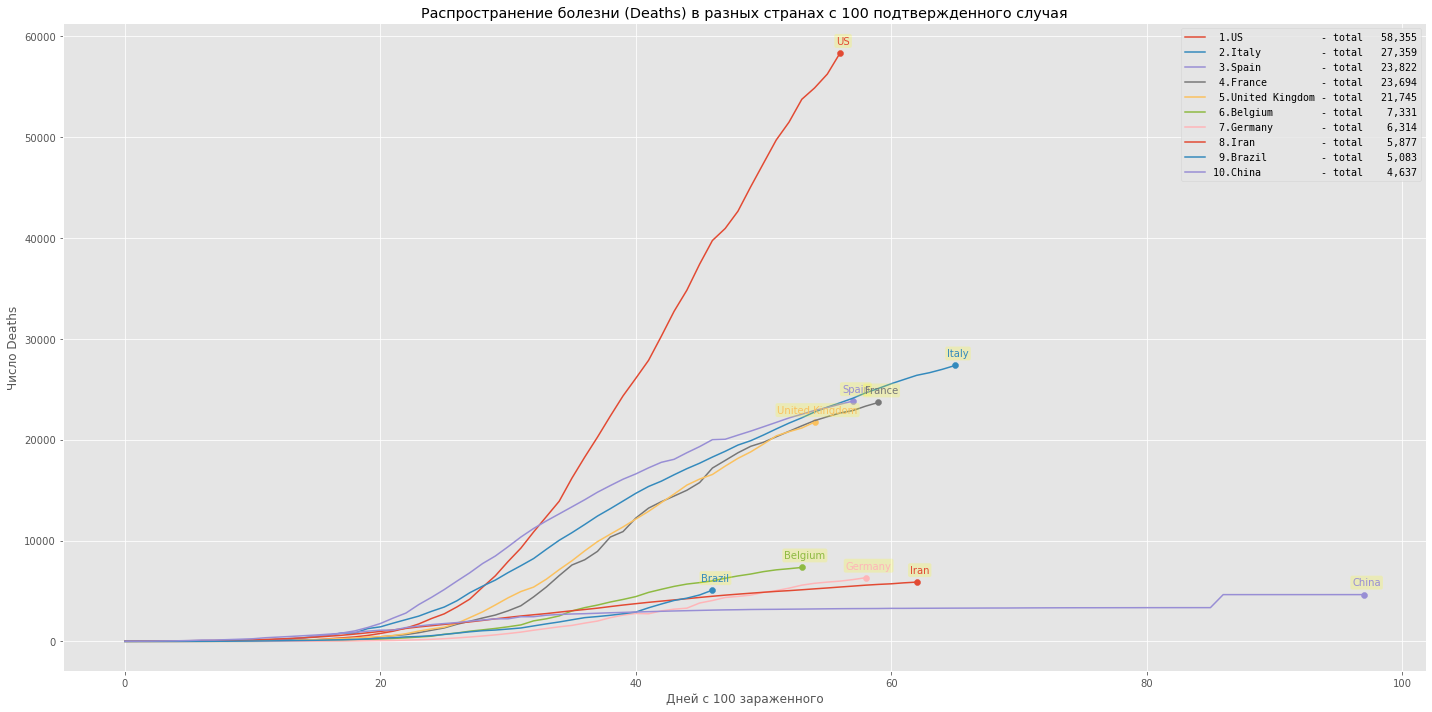

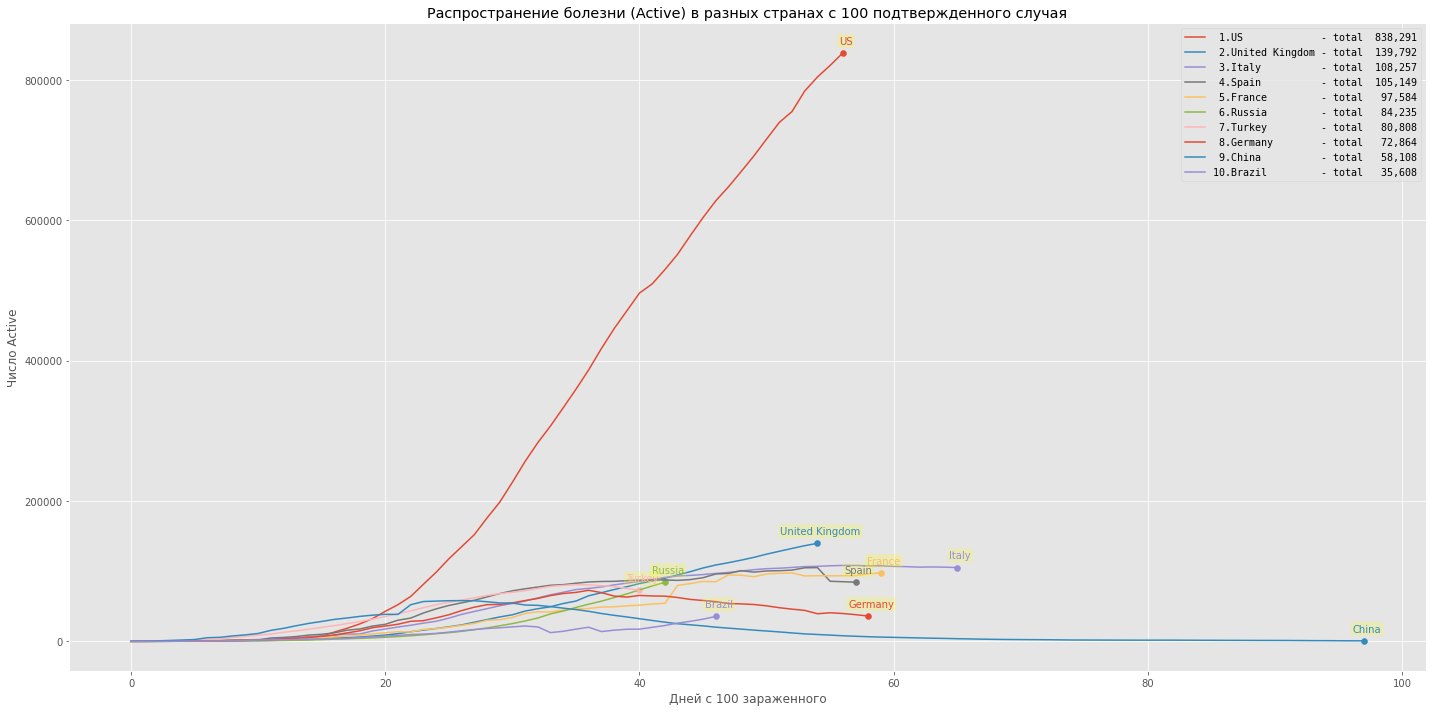

In [22]:
for col in ['Confirmed', 'Recovered', 'Deaths', 'Active']:
    plt.figure(figsize=(20,10), facecolor='w')
    for i, (name, row) in enumerate(( __df
                                     .groupby('Country/Region')[[col, 'n_day']]
                                     .agg(lambda x: list(x))
                                     .join(
                                         __df.groupby('Country/Region')[col]
                                        .max()
                                        .astype(np.int32),
                                         rsuffix='_max')
                                     .sort_values(f'{col}_max', ascending=False)
                                     .head(10)
                                    ).iterrows()):
        color = plt.plot(row['n_day'], row[col], label=f'{i+1:>2}.{name:<15}- total {row[f"{col}_max"]:>8,d}' if i < 20 else None)[0].get_color()
        if 0 <= i < 10:
            plt.scatter(row['n_day'][-1], row[col][-1], color=color, alpha=1)
            plt.annotate(f'{name}', (row['n_day'][-1], row[col][-1]),
                         xytext=(3, 7), textcoords='offset points', ha='center', va='bottom', color=color,
                         bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.2))
    plt.legend(prop={'family': 'monospace'})
    plt.xlabel('Дней с 100 зараженного')
    plt.ylabel(f'Число {col}')
#     plt.ylim([-4000, 1.1 * __df.groupby('Country/Region')[col].max().sort_values()[-2]])
    plt.title(f'Распространение болезни ({col}) в разных странах с 100 подтвержденного случая');
    plt.tight_layout()
    plt.show()

### Данные на 2020-04-23

Все показатели, кроме выздоровивших похожи.
Лидирует США.
Во некоторых странах ситуация намного хуже чем в Китае.

По количеству выздоровивших неожиданно лидирует Германия.

In [23]:
import seaborn as sns

def plot_corr(D, size):
    corr = D.corr()
#     corr = np.abs(corr)
    f, ax = plt.subplots(figsize=(size, size))
    cmap = plt.cm.Oranges
    sns.heatmap(corr, cmap=cmap,
                xticklabels=corr.columns,
                yticklabels=corr.columns)
    
from IPython.display import display

In [24]:
for col in ['Confirmed', 'Recovered', 'Deaths', 'Active']:
    print(f'Корреляция по признаку {col}')
    display(
        (__df
         .groupby('Country/Region')[[col, 'n_day']]
         .agg(lambda x: list(x))
         .join(
             __df.groupby('Country/Region')[col]
            .max()
            .astype(np.int32),
             rsuffix='_max')
         .sort_values(f'{col}_max', ascending=False)
         .head(10)
        )
        .T
        .apply(lambda x: pd.Series(x.loc[col]))
        .corr()
        .style
        .background_gradient(cmap='coolwarm')
        .set_precision(2)
    )

Корреляция по признаку Confirmed


Корреляция по признаку Recovered


Корреляция по признаку Deaths


Корреляция по признаку Active


### Данные на 2020-04-23

По всем показателям, кроме Recovered Китай не похож на остальные страны.
В топе стран высокая кореляция по наблюдаемым величинам.
По Recovered все страны похожи

1.7 Для первых 5 стран из топ-10 и России постойте сравнительные графики. Изучите как изменялись значения отношений погибших/выздоровивших, погибших/заболевших, заболевших/общее число жителей, ваш вариант...

In [25]:
!wget -O population.csv https://raw.githubusercontent.com/datasets/population/master/data/population.csv --no-check-certificate -q

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc


In [26]:
top_c = list(set(df_c.groupby('Country/Region')['Confirmed'].max().sort_values(ascending=False).head(5).index) | {'Russia'})
top_c

['US', 'Italy', 'Russia', 'United Kingdom', 'Spain', 'France']

In [27]:
population = pd.read_csv('population.csv', sep=',')
population['Country Name'].replace({'United States': 'US', 'Russian Federation': 'Russia', 'Iran, Islamic Rep.': 'Iran'}, inplace=True)
population = population[population['Country Name'].isin(top_c)]

population = population.loc[population.groupby('Country Name')['Year'].idxmax().values].set_index('Country Name')['Value']
population.name = 'population'
population.index.name = 'Country/Region'

set(population.index) - set(top_c)

set()

In [28]:
__df = df_c[df_c['Country/Region'].isin(top_c)]
# region_start_100 = df_c[df_c['Confirmed'] >= 100].groupby('Country/Region')['Date'].min()
# region_start_100.name = 'd_start100'
__df = __df.join(region_start_100, on='Country/Region').join(population, on='Country/Region')
__df['n_day'] = (__df['Date'] - __df['d_start100']).dt.days
__df = __df[__df['n_day'] > 0]
__df['Active'] = __df['Confirmed'] - __df['Recovered'] - __df['Deaths']
__df['Deaths/Recovered'] = __df['Deaths'] / (__df['Recovered'] + 1) # prevent divide by 0
__df['Deaths/Confirmed'] = __df['Deaths'] / __df['Confirmed']
__df['Confirmed/population'] = __df['Confirmed'] / __df['population']
__df.head()

Date Country/Region  Confirmed  Recovered  Deaths d_start100  \
6189 2020-02-24          Italy     229.00       1.00    7.00 2020-02-23   
6374 2020-02-25          Italy     322.00       1.00   10.00 2020-02-23   
6559 2020-02-26          Italy     453.00       3.00   12.00 2020-02-23   
6744 2020-02-27          Italy     655.00      45.00   17.00 2020-02-23   
6929 2020-02-28          Italy     888.00      46.00   21.00 2020-02-23   

      population  n_day  Active  Deaths/Recovered  Deaths/Confirmed  \
6189    60421760      1  221.00              3.50              0.03   
6374    60421760      2  311.00              5.00              0.03   
6559    60421760      3  438.00              3.00              0.03   
6744    60421760      4  593.00              0.37              0.03   
6929    60421760      5  821.00              0.45              0.02   

      Confirmed/population  
6189                  0.00  
6374                  0.00  
6559                  0.00  
6744                  0.00  
6929                  0.00

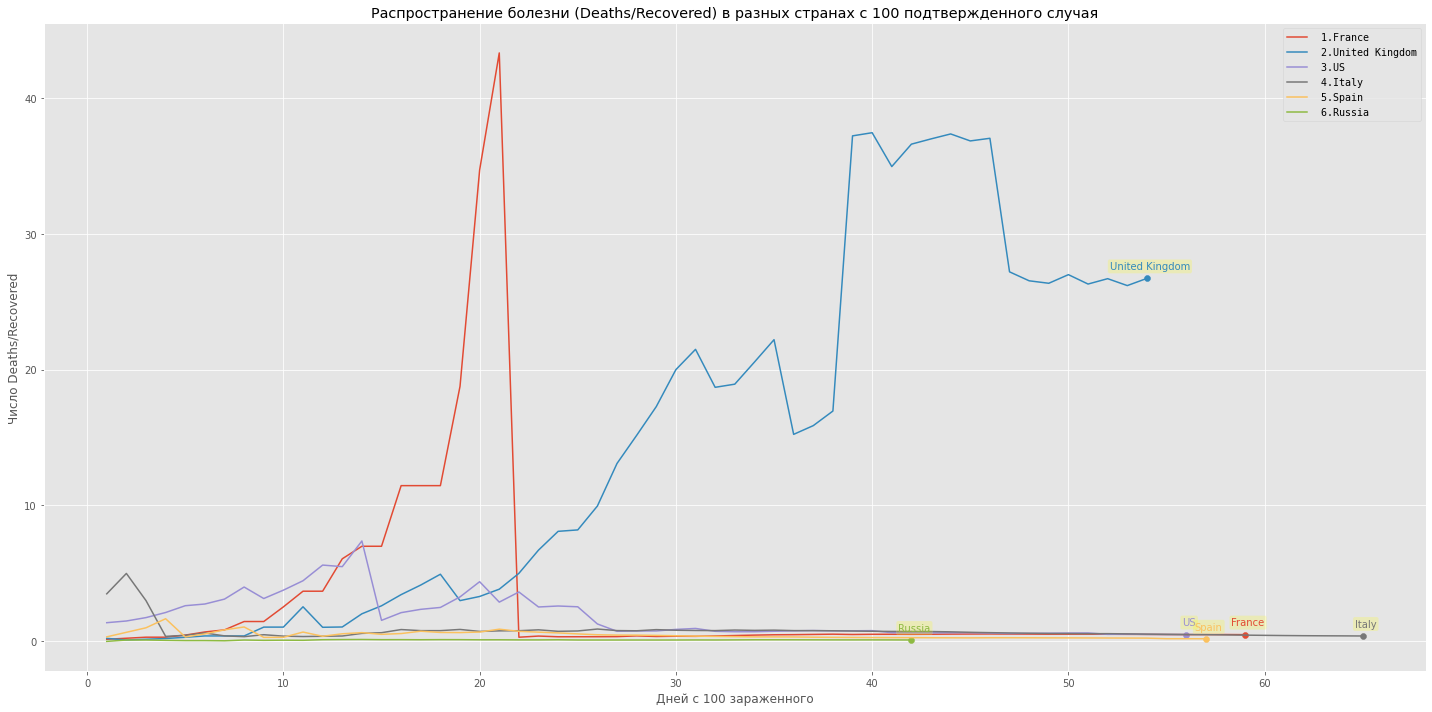

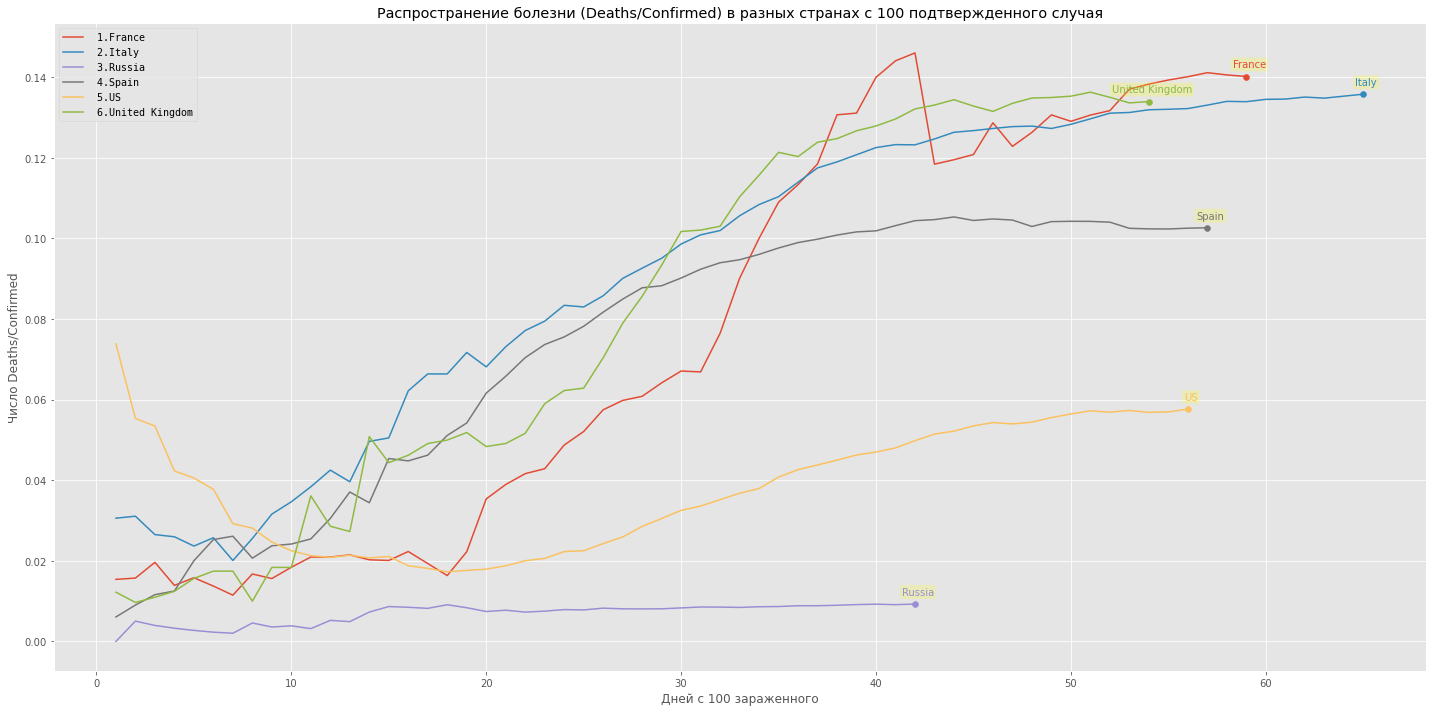

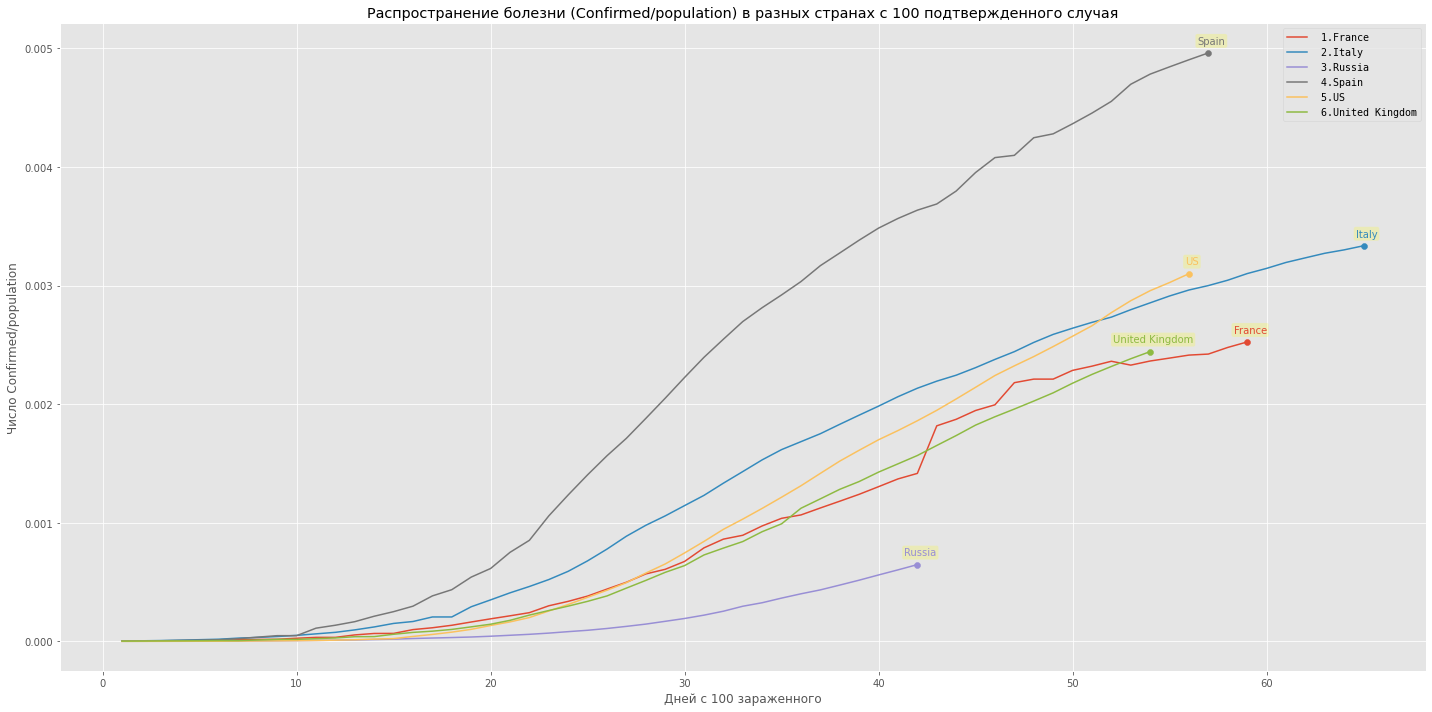

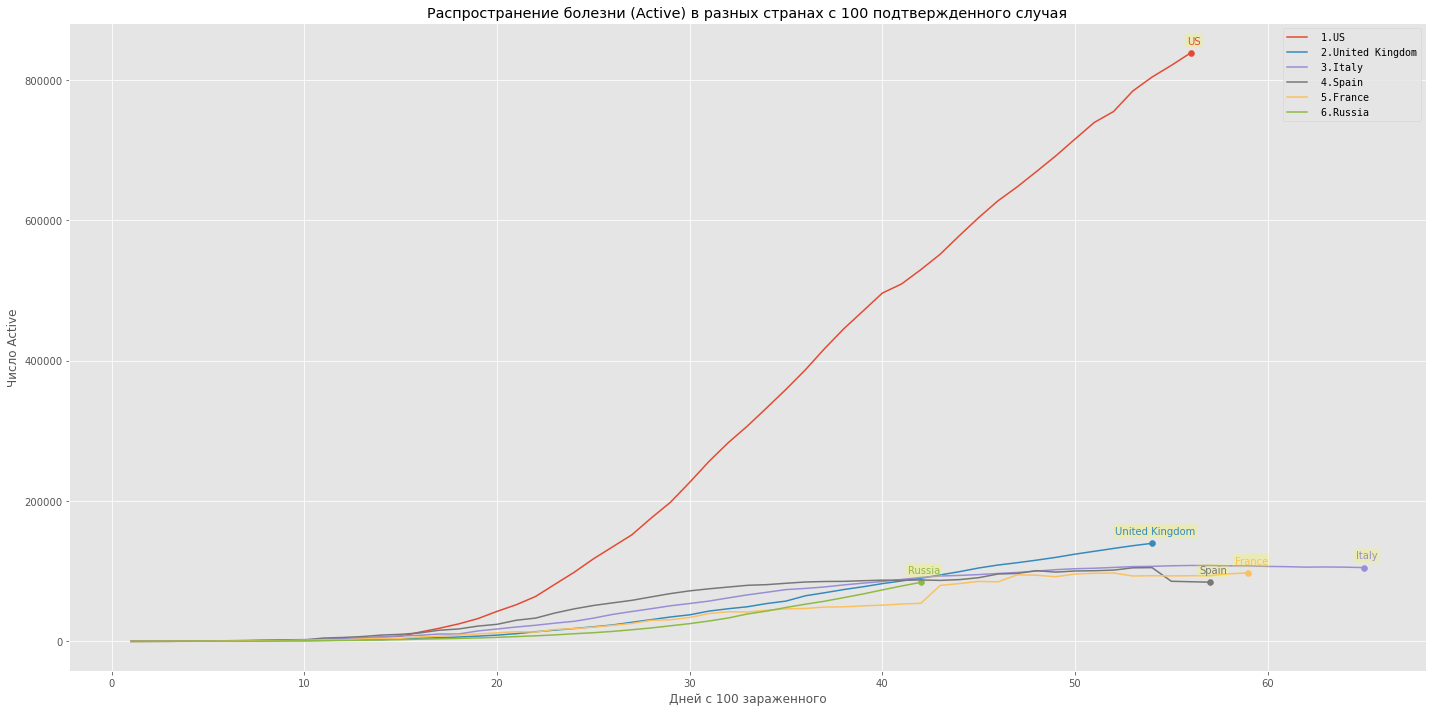

In [29]:
for col in ['Deaths/Recovered', 'Deaths/Confirmed', 'Confirmed/population', 'Active']:
    plt.figure(figsize=(20,10), facecolor='w')
    for i, (name, row) in enumerate(( __df
                                     .groupby('Country/Region')[[col, 'n_day']]
                                     .agg(lambda x: list(x))
                                     .join(
                                         __df.groupby('Country/Region')[col]
                                        .max()
                                        .astype(np.int32),
                                         rsuffix='_max')
                                     .sort_values(f'{col}_max', ascending=False)
                                    ).iterrows()):
        color = plt.plot(row['n_day'], row[col], label=f'{i+1:>2}.{name:<10}')[0].get_color()
        plt.scatter(row['n_day'][-1], row[col][-1], color=color, alpha=1)
        plt.annotate(f'{name}', (row['n_day'][-1], row[col][-1]),
                     xytext=(3, 7), textcoords='offset points', ha='center', va='bottom', color=color,
                     bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.2))
    plt.legend(prop={'family': 'monospace'})
    plt.xlabel('Дней с 100 зараженного')
    plt.ylabel(f'Число {col}')
    plt.title(f'Распространение болезни ({col}) в разных странах с 100 подтвержденного случая');
    plt.tight_layout()
    plt.show()

### Данные на 2020-04-23

Deaths/Recovered: С начала заболевания много людей погибает, а количество выздоровивших растет с некоторой задержкой, поэтому есть всплеск данного показателя в начале болезни в странах.

Deaths/Confirmed: В России подозрительно низкий показатель смертности. 
Если построить аналогичный график для 25 стран, то у России данный показатель также низок, на уровне Саудовской Аравии (в отличии от России, у нее он падал со временем).
По всей видимости, в России по другому считают стасистику погибших (умерших от вируса, а не умерших с вирусом).
Также, возможно, занижают показатели для более низкого значения смертности

Confirmed/population: Видно, что в США хоть и больше всего зараженных, но население страны так же большое.
По данному показателю лидирует Испания.
Также заметно, что заболело в каждой стране менее 1% населения, а в России менее 0,1%.

Active: В Германии заболевание идет на спад, в Италии, Испании и Франции рост прекращается.
По России трудно говорить о начале пика заболевших.
В США все плохо.

1.8 Выделите временной ряд по одному из целевых признаков. Для выделенного временного ряда:
  - Представьте временной ряд в виде последовательности разницы между значениями. Рассчитайте лаги, выведите их на графике.
  - Попробуйте декомпозировать временной ряд. Постройте график тренда.
  - Что вы можете сказать о стационарности временного ряда? 

In [30]:
__df = pd.concat([df_c[['Date', 'Country/Region', 'Confirmed']], df_c.shift(df_c.groupby('Date').size().unique()[0])['Confirmed']], axis=1).dropna()
__df.columns = ['Date', 'Country/Region', 'Confirmed', 'Confirmed_lag']
__df['lag'] = __df['Confirmed'] - __df['Confirmed_lag']

region_start = __df[__df['Confirmed'] > 0].groupby('Country/Region')['Date'].min()
region_start.name = 'd_start'
__df = pd.merge(__df[__df['Confirmed'] > 0], region_start, on='Country/Region')
__df['n_day'] = (__df['Date'] - __df['d_start']).dt.days
__df['day_of_week'] = __df['Date'].dt.dayofweek
__df

Date Country/Region  Confirmed  Confirmed_lag    lag    d_start  \
0     2020-01-23          China     643.00         548.00  95.00 2020-01-23   
1     2020-01-24          China     920.00         643.00 277.00 2020-01-23   
2     2020-01-25          China    1406.00         920.00 486.00 2020-01-23   
3     2020-01-26          China    2075.00        1406.00 669.00 2020-01-23   
4     2020-01-27          China    2877.00        2075.00 802.00 2020-01-23   
...          ...            ...        ...            ...    ...        ...   
10372 2020-04-24          Yemen       1.00           1.00   0.00 2020-04-10   
10373 2020-04-25          Yemen       1.00           1.00   0.00 2020-04-10   
10374 2020-04-26          Yemen       1.00           1.00   0.00 2020-04-10   
10375 2020-04-27          Yemen       1.00           1.00   0.00 2020-04-10   
10376 2020-04-28          Yemen       1.00           1.00   0.00 2020-04-10   

       n_day  day_of_week  
0          0            3  
1          1            4  
2          2            5  
3          3            6  
4          4            0  
...      ...          ...  
10372     14            4  
10373     15            5  
10374     16            6  
10375     17            0  
10376     18            1  

[10377 rows x 8 columns]

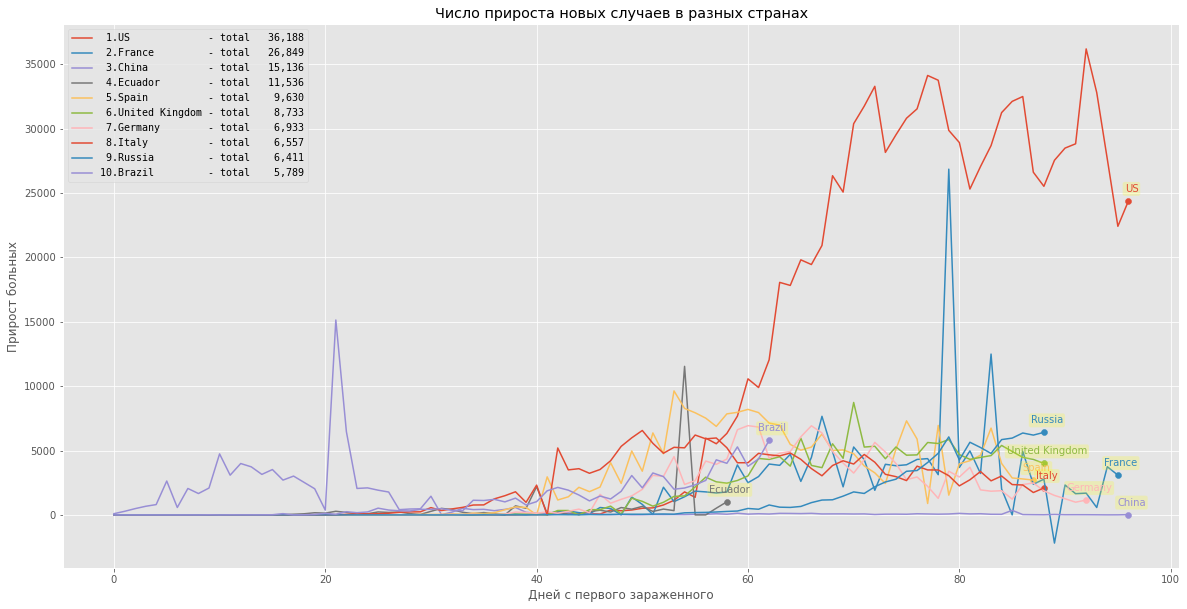

In [31]:
plt.figure(figsize=(20,10), facecolor='w')
for i, (name, row) in enumerate(( __df
                                 .groupby('Country/Region')[['lag', 'n_day']]
                                 .agg(lambda x: list(x))
                                 .join(
                                     __df.groupby('Country/Region')['lag']
                                    .max()
                                    .astype(np.int32),
                                     rsuffix='_max')
                                 .sort_values('lag_max', ascending=False)
                                 .head(10)
                                ).iterrows()):
    color = plt.plot(row['n_day'], row['lag'], label=f'{i+1:>2}.{name:<15}- total {row["lag_max"]:>8,d}' if i < 20 else None)[0].get_color()
    plt.scatter(row['n_day'][-1], row['lag'][-1], color=color, alpha=1)
    plt.annotate(f'{name}', (row['n_day'][-1], row['lag'][-1]),
                 xytext=(3, 7), textcoords='offset points', ha='center', va='bottom', color=color,
                 bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.2))
plt.legend(prop={'family': 'monospace'})
plt.xlabel('Дней с первого зараженного')
plt.ylabel('Прирост больных')
plt.title('Число прироста новых случаев в разных странах');

Ряд нестационарен, заметны некоторые циклические колебания (по дням недели?).

Теоретически не может быть стационарным, когда-то все выздоровят.
В Китае количество новых случаев давно стало нулевым

1.9 Для любого интересующего Вас временного ряда постройте графики ACF и PACF. Сделайте выводы. 

In [32]:
from statsmodels.tsa.stattools import acf, pacf

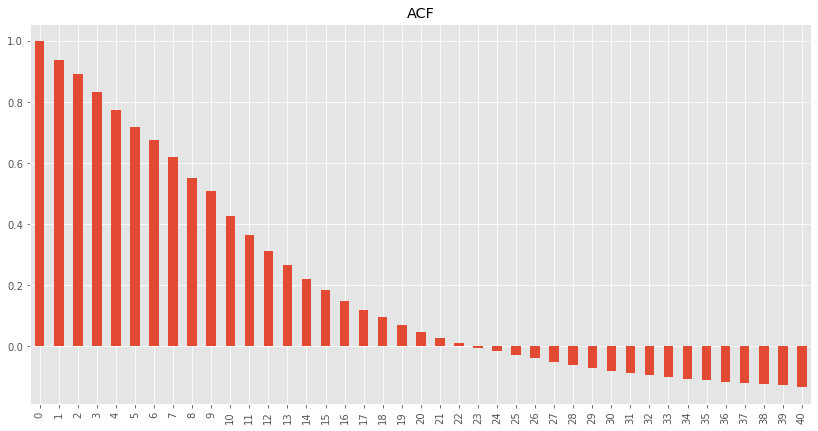

In [33]:
pd.Series(acf(__df[__df['Country/Region'] == 'Russia']['lag'])).plot.bar(figsize=(14,7), title='ACF');

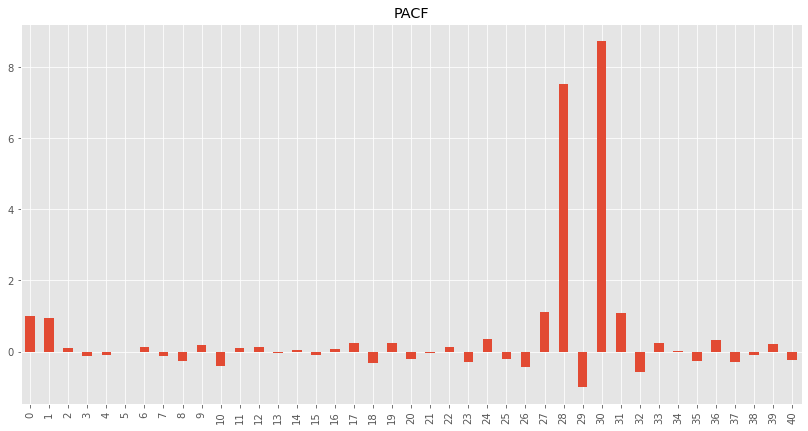

In [34]:
pd.Series(pacf(__df[__df['Country/Region'] == 'Russia']['lag'])).plot.bar(figsize=(14,7), title='PACF');

оптимальный параметры для модели ARMA (1, 2)

#### 1.10. Изучаемый Вами датасет отражает текущую мировую статистику распространения болезни. Однако эти данные не дают нам возможноси предположить о возможных факторах, которые влюяют на скорость распространения, летальности, заразность и тд. Поэтому в наш датасет можно добавить новые признаки из других наборов данных, которые могут не только помочь при прогнозировании временного ряда, но и определить наиболее значимые факторы.

- Добавьте новый признак "количество дней со дня первого случая заражения". Добавьте еще не менее 5 новых признаков в датасет, которые могут быть значимым фактором распространения вируса. Сохраните полученный датасет, вы можете его использовать во второй части домашнего задания.
- Исследуйте как добавленные признаки соотносятся с трендами распространения короновируса в некоторых странах. Сделайте выводы.

*Примеры признаков - количество дней со начала карантина, конинент, плотность населения, количество употребляемого алкоголя, летучих мышей, алкоголя, крокодилов на душу населения, количество туристов в год, уровень безработицы, температура, количество игроков в Plague Inc., средний возраст или продолжительность жизни и так далее. Вы можете использовать любой найденный датасет. Главное, чтобы у Вас получилось скомбинировать данные.*

  Примеры датасеты:
  1. [500 Cities: Local Data for Better Health (2019)](https://www.kaggle.com/jaimeblasco/500-cities-local-data-for-better-health-2019)
  2. [Daily global surface summary from over 9000 weather stations from 1929 to now](https://www.kaggle.com/noaa/gsod)
  3. [Population by Country - 2020](https://www.kaggle.com/tanuprabhu/population-by-country-2020)



In [35]:
population = pd.read_csv('population.csv', sep=',')
population['Country Name'].replace(
    {
        'United States': 'US', 
        'Russian Federation': 'Russia', 
        'Iran, Islamic Rep.': 'Iran',
        'Czech Republic': 'Czechia',
        'Egypt, Arab Rep.': 'Egypt',
        'Korea, Rep.': 'Korea, South',
        'Slovak Republic': 'Slovakia',        
    }, inplace=True)

population = population.loc[population.groupby('Country Name')['Year'].idxmax().values].set_index('Country Name')['Value']
population.name = 'population'
population.index.name = 'Country/Region'

In [210]:
__df = df_c.copy()
__df['cfr'] = __df['Deaths'] / __df['Confirmed']

__df = pd.concat([__df, __df.shift(df_c.groupby('Date').size().unique()[0])['cfr']], axis=1).dropna()
cols = list(__df.columns)
cols[-1] = cols[-1] + '_lag'
__df.columns = cols
__df['lag'] = __df['cfr'] - __df['cfr_lag']

region_start1 = __df[__df['Confirmed'] > 0].groupby('Country/Region')['Date'].min()
region_start1.name = 'd_start1'
region_start100 = __df[__df['Confirmed'] > 100].groupby('Country/Region')['Date'].min()
region_start100.name = 'd_start100'
region_start1000 = __df[__df['Confirmed'] > 1000].groupby('Country/Region')['Date'].min()
region_start1000.name = 'd_start1000'
__df = (
    __df[__df['Confirmed'] > 0]
    .join(region_start1, on='Country/Region', how='inner')
    .join(region_start100, on='Country/Region', how='inner')
    .join(region_start1000, on='Country/Region', how='inner')
    .join(population, on='Country/Region', how='inner')
)
__df['active'] = __df['Confirmed'] - __df['Recovered'] - __df['Deaths']
__df['n_day1'] = (__df['Date'] - __df['d_start1']).dt.days
__df['n_day100'] = (__df['Date'] - __df['d_start100']).dt.days
__df['n_day1000'] = (__df['Date'] - __df['d_start1000']).dt.days

__df['confirmed_rate'] = __df['Confirmed'] / __df['population']
__df['recovered_rate'] = __df['Recovered'] / __df['population']
__df['deaths_rate'] = __df['Deaths'] / __df['population']
__df['active_rate'] = __df['active'] / __df['population']

__df['day_of_week'] = __df['Date'].dt.dayofweek
__df = __df[__df['n_day100'] >= 0]
__df.drop(columns=['cfr_lag', 'd_start1', 'd_start100', 'd_start1000', 'population'], inplace=True)
__df.reset_index(drop=True, inplace=True)
__df.to_csv('covid_features.csv')
__df.to_pickle('covid_features.pkl')
__df

Date Country/Region  Confirmed  Recovered  Deaths  cfr   lag  \
0    2020-01-23          China     643.00      30.00   18.00 0.03 -0.00   
1    2020-01-24          China     920.00      36.00   26.00 0.03  0.00   
2    2020-01-25          China    1406.00      39.00   42.00 0.03  0.00   
3    2020-01-26          China    2075.00      49.00   56.00 0.03 -0.00   
4    2020-01-27          China    2877.00      58.00   82.00 0.03  0.00   
...         ...            ...        ...        ...     ...  ...   ...   
3844 2020-04-24       Djibouti     999.00     330.00    2.00 0.00 -0.00   
3845 2020-04-25       Djibouti    1008.00     373.00    2.00 0.00 -0.00   
3846 2020-04-26       Djibouti    1023.00     411.00    2.00 0.00 -0.00   
3847 2020-04-27       Djibouti    1035.00     477.00    2.00 0.00 -0.00   
3848 2020-04-28       Djibouti    1072.00     498.00    2.00 0.00 -0.00   

      active  n_day1  n_day100  n_day1000  confirmed_rate  recovered_rate  \
0     595.00       0         0         -2            0.00            0.00   
1     858.00       1         1         -1            0.00            0.00   
2    1325.00       2         2          0            0.00            0.00   
3    1970.00       3         3          1            0.00            0.00   
4    2737.00       4         4          2            0.00            0.00   
...      ...     ...       ...        ...             ...             ...   
3844  667.00      36        16         -1            0.00            0.00   
3845  633.00      37        17          0            0.00            0.00   
3846  610.00      38        18          1            0.00            0.00   
3847  556.00      39        19          2            0.00            0.00   
3848  572.00      40        20          3            0.00            0.00   

      deaths_rate  active_rate  day_of_week  
0            0.00         0.00            3  
1            0.00         0.00            4  
2            0.00         0.00            5  
3            0.00         0.00            6  
4            0.00         0.00            0  
...           ...          ...          ...  
3844         0.00         0.00            4  
3845         0.00         0.00            5  
3846         0.00         0.00            6  
3847         0.00         0.00            0  
3848         0.00         0.00            1  

[3849 rows x 16 columns]

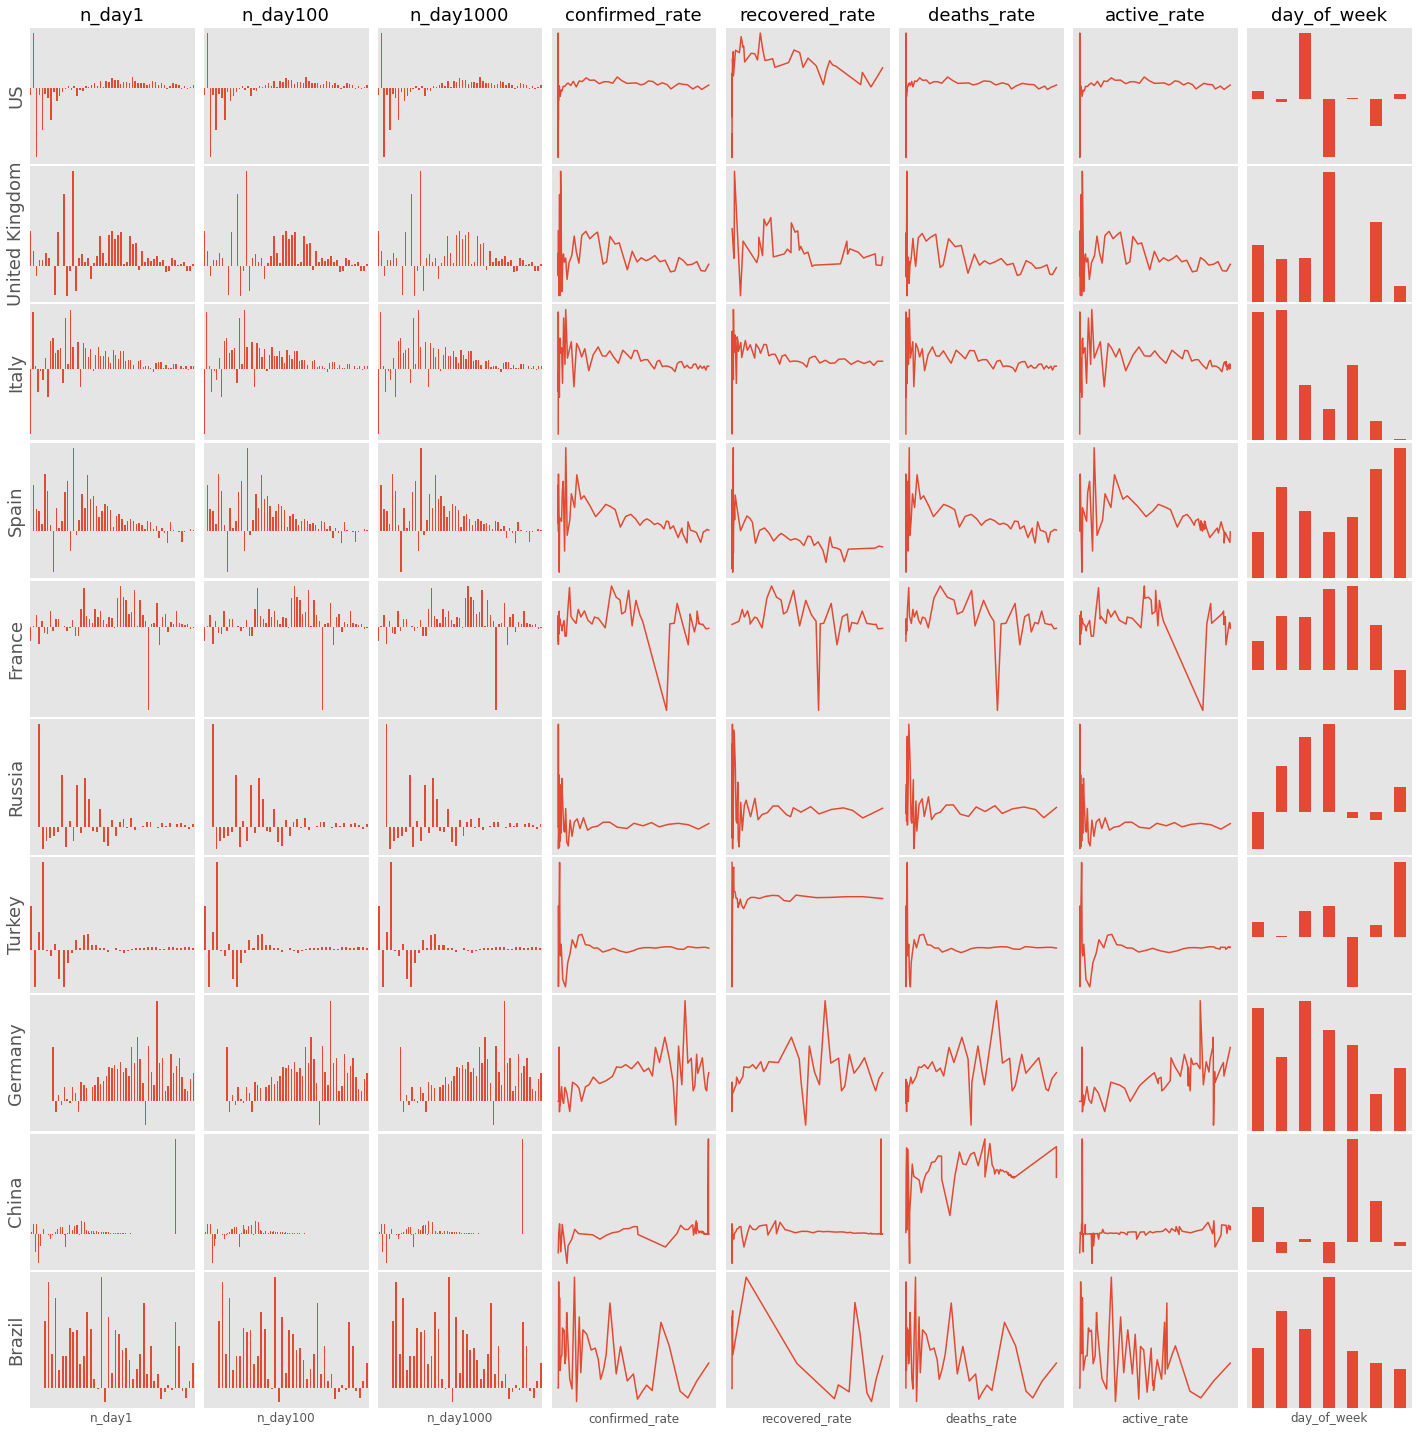

In [149]:
plt.figure(figsize=(20, 20), facecolor='w')
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
plot_num = 1
for i, (country, active) in enumerate(__df.groupby('Country/Region')['active'].max().sort_values(ascending=False).head(10).iteritems()):
    ___df = __df[__df['Country/Region'] == country]
    for param in ['n_day1', 'n_day100', 'n_day1000', 'confirmed_rate', 'recovered_rate', 'deaths_rate', 'active_rate', 'day_of_week']:
        
        plt.subplot(10, 8, plot_num)
        if i == 0:
            plt.title(param, size=18)
        if param == 'n_day1':
            plt.ylabel(country, fontsize=18)
        if ___df.dtypes[param] == np.int64:
            ___df.groupby(param)['lag'].mean().plot.bar()
        else:
            ___df.groupby(param)['lag'].mean().plot()
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

На графиках представлена зависимость прироста смертности от параметра дня в разных странах

### 1.11 Выводы

выводы были после каждого пункта

## 2. Прогнозирование временного ряда

Теперь вам предстоит построить несколько моделей и спрогнозировать временной ряд для такого показателя как летальности от вируса. Летальность можно рассчитывать по формуле:

$$ CFR = \frac{Deaths}{Confirmed} $$

Для каждого типа модели сделайте несколько прогнозов для не менее 3 разных стран/регионов/другое (на ваш обоснованный выбор). Главное, чтобы каждый из типов моделей прознозировал одинаковый набор данных, чтобы в конце можно было сделать выводы о качестве работы той или иной модели.

Метрика качества RMSE. Не забудьте разбить данные временной ряд на данные для обучения и тестовые.

Не забывайте сопровождать ваш код комментариями, графиками и выводами.

In [150]:
import datetime

from sklearn.metrics import mean_squared_error

In [151]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

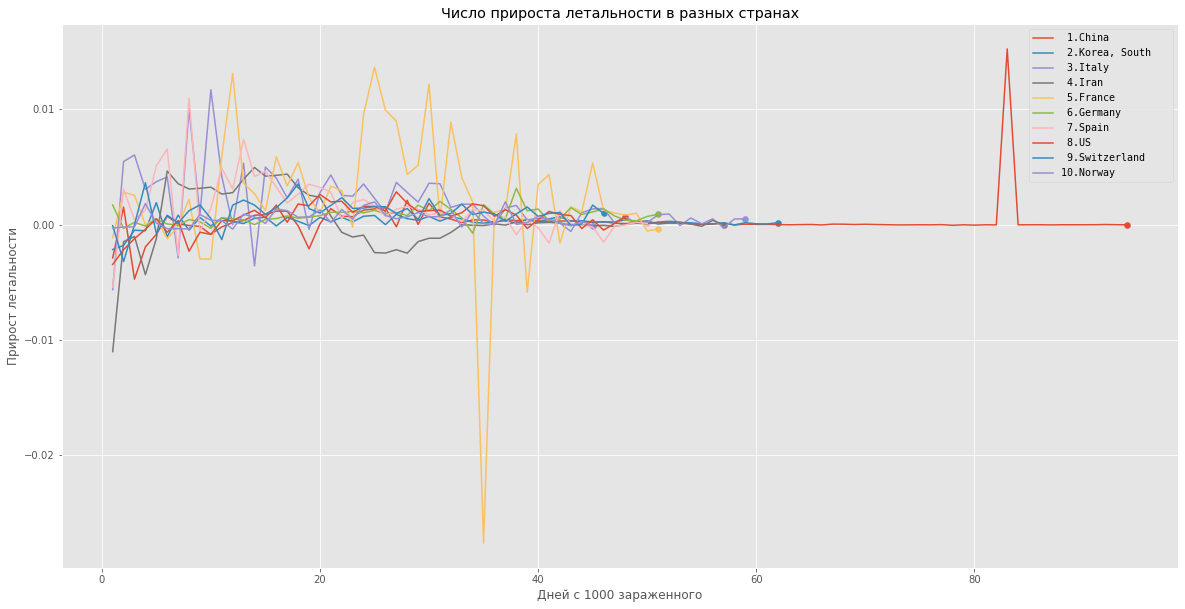

In [152]:
plt.figure(figsize=(20,10), facecolor='w')
for i, (name, row) in enumerate(( __df[__df['n_day1000'] > 0]
                                 .groupby('Country/Region')[['lag', 'n_day1000']]
                                 .agg(lambda x: list(x))
                                 .join(
                                     __df.groupby('Country/Region')['n_day1000']
                                    .max()
                                    .astype(np.int32),
                                     rsuffix='_max')
                                 .sort_values('n_day1000_max', ascending=False)
                                 .head(10)
                                ).iterrows()):
    color = plt.plot(row['n_day1000'], row['lag'], label=f'{i+1:>2}.{name:<15}')[0].get_color()
    plt.scatter(row['n_day1000'][-1], row['lag'][-1], color=color, alpha=1)
plt.legend(prop={'family': 'monospace'})
plt.xlabel('Дней с 1000 зараженного')
plt.ylabel('Прирост летальности')
plt.title('Число прироста летальности в разных странах');

In [153]:
split_date = __df['Date'].max() - datetime.timedelta(10)
print(split_date)
train = __df[__df['Date'] < split_date].copy()
test = __df[__df['Date'] >= split_date].copy()

2020-04-18 00:00:00


In [42]:
all_countries = list(train['Country/Region'].unique())
top_countries = ['US', 'Russia', 'Spain']

In [43]:
def measure_quality(df, name):
    per_country = (
        df
        .groupby('Country/Region')
        .agg(lambda x: list(x))
        .apply(lambda x: rmse(x['cfr'], x['cfr_r']) if np.isnan(x['cfr_r']).sum() == 0 else np.nan, axis=1)        
    )
    per_country.name = 'rmse'
    world = pd.merge(per_country, population, left_index=True, right_index=True, how='inner')
    
    per_country['World'] = (world['rmse'] * world['population']).sum() / world['population'].sum()
    per_country.name = name
    return per_country

In [44]:
class Experimens:
    def __init__(self, top_cols):
        self._df = pd.DataFrame(columns=['World'] + top_cols)
        
    def add(self, data, name):
        quality = measure_quality(data, name)
        self._df = self._df.append(quality, verify_integrity=True)
        return self.show
    
    @property
    def show(self):
        return self._df.copy()

In [45]:
ex = Experimens(top_countries)

### 2.1 Прогнозирование средним (Mean Constant Model)

In [46]:
def plot_predict(predict, title=None):
    plt.figure(figsize=(14, 7))
    for country in top_countries:
        _tr = train[train['Country/Region'] == country]

        _te = predict[predict['Country/Region'] == country]

        color = plt.plot(_tr['Date'], _tr['cfr'], label=country + ' train')[0].get_color()
        plt.plot(_te['Date'], _te['cfr'], label=country + ' test', color=color, marker='+')
        plt.plot(_te['Date'], _te['cfr_r'], label=country + ' predict', color=color, marker='o')
    plt.title(title)
    plt.legend();

World   US  Russia  Spain  Afghanistan  Algeria  Argentina  Armenia  \
const   0.02 0.02    0.00   0.04         0.00     0.03       0.02     0.01   

       Australia  Austria  ...  Slovenia  South Africa  Sweden  Switzerland  \
const       0.00     0.02  ...      0.04          0.01    0.08         0.03   

       Thailand  Turkey  Ukraine  United Arab Emirates  United Kingdom  \
const      0.01    0.00     0.00                  0.00            0.07   

       Uzbekistan  
const        0.00  

[1 rows x 87 columns]

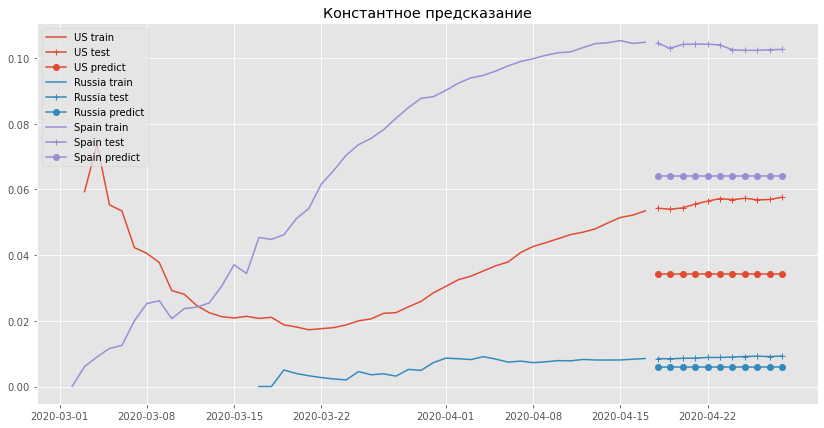

In [47]:
predict = train.groupby('Country/Region')['cfr'].mean()
predict = test[['Date', 'Country/Region', 'lag', 'cfr']].join(predict, on='Country/Region', rsuffix='_r')
plot_predict(predict, 'Константное предсказание')
ex.add(predict, 'const')

#### Mean const lag

In [48]:
def flatten(df):
    res = []
    for index, row in df.iterrows():
        for r2 in zip(*row):
            new_row = {
                df.index.name: index
            }
            for keys, values in zip(row.keys(), r2):
                new_row[keys] = values
            res.append(new_row)
    return pd.DataFrame(res)

def predict_to_normal(data, data_start):
    data_start = data_start[data_start['Date'] == data_start['Date'].max()].set_index('Country/Region')[['cfr']]
    
    df = data[['Date', 'Country/Region', 'lag', 'lag_r']].groupby('Country/Region').agg(lambda x: list(x))
    df['cfr'] = df['lag'].map(lambda x: list(np.array(x).cumsum()))
    df['cfr_r'] = df['lag_r'].map(lambda x: list(np.array(x).cumsum()))
    df.drop(columns=['lag', 'lag_r'], inplace=True)
    df = flatten(df).join(data_start, rsuffix='_begin', on='Country/Region')
    df['cfr'] = df['cfr'] + df['cfr_begin']
    df['cfr_r'] = df['cfr_r'] + df['cfr_begin']
    df.drop(columns=['cfr_begin'], inplace=True)
    return df.copy()

World   US  Russia  Spain  Afghanistan  Algeria  Argentina  \
const       0.02 0.02    0.00   0.04         0.00     0.03       0.02   
const lag   0.01 0.00    0.00   0.02         0.00     0.03       0.00   

           Armenia  Australia  Austria  ...  Slovenia  South Africa  Sweden  \
const         0.01       0.00     0.02  ...      0.04          0.01    0.08   
const lag     0.00       0.01     0.00  ...      0.00          0.00    0.01   

           Switzerland  Thailand  Turkey  Ukraine  United Arab Emirates  \
const             0.03      0.01    0.00     0.00                  0.00   
const lag         0.00      0.00    0.00     0.00                  0.00   

           United Kingdom  Uzbekistan  
const                0.07        0.00  
const lag            0.02        0.00  

[2 rows x 87 columns]

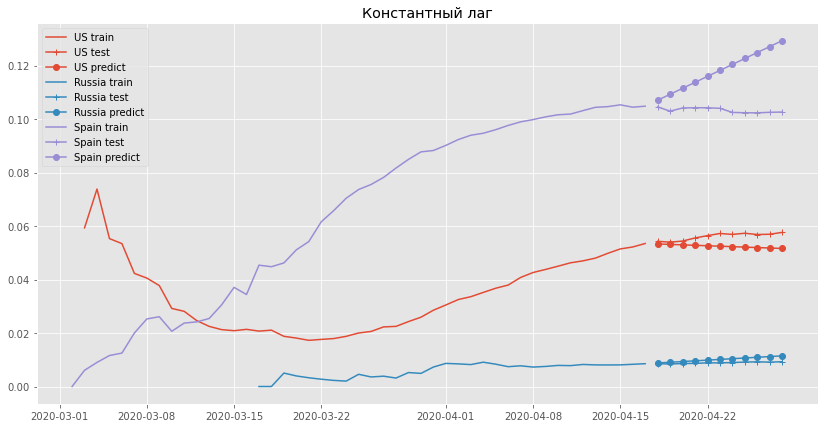

In [49]:
predict = train.groupby('Country/Region')['lag'].mean()
predict = test[['Date', 'Country/Region', 'lag']].join(predict, on='Country/Region', rsuffix='_r')
predict = predict_to_normal(predict, train)
plot_predict(predict, 'Константный лаг')
ex.add(predict, 'const lag')

#### 2.2 Линейная модель (Linear Trend Model) 

In [50]:
import statsmodels.formula.api as smf
from tqdm import tqdm_notebook as tqdm

World   US  Russia  Spain  Afghanistan  Algeria  Argentina  \
const       0.02 0.02    0.00   0.04         0.00     0.03       0.02   
const lag   0.01 0.00    0.00   0.02         0.00     0.03       0.00   
linear      0.01 0.02    0.00   0.01         0.02     0.08       0.02   

           Armenia  Australia  Austria  ...  Slovenia  South Africa  Sweden  \
const         0.01       0.00     0.02  ...      0.04          0.01    0.08   
const lag     0.00       0.01     0.00  ...      0.00          0.00    0.01   
linear        0.00       0.01     0.00  ...      0.01          0.01    0.02   

           Switzerland  Thailand  Turkey  Ukraine  United Arab Emirates  \
const             0.03      0.01    0.00     0.00                  0.00   
const lag         0.00      0.00    0.00     0.00                  0.00   
linear            0.01      0.01    0.00     0.00                  0.01   

           United Kingdom  Uzbekistan  
const                0.07        0.00  
const lag            0.02        0.00  
linear               0.02        0.00  

[3 rows x 87 columns]

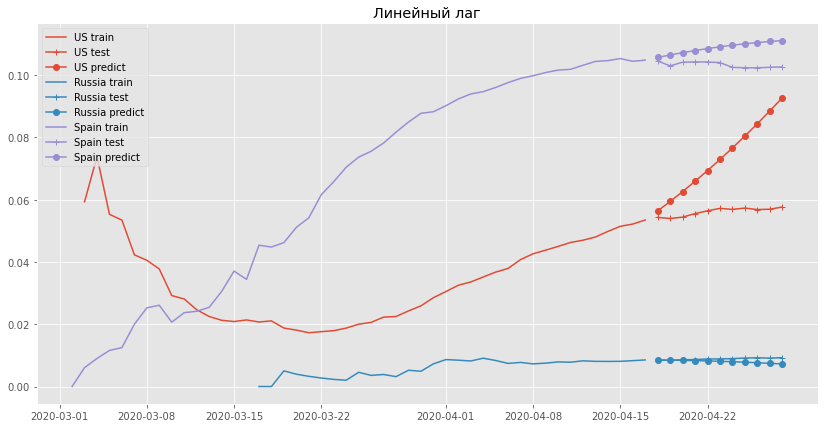

In [51]:
predict = test[['Date', 'n_day1', 'Country/Region', 'lag']].copy()
predict['lag_r'] = None

for country in tqdm(all_countries):
    model_linear = smf.ols('lag ~ n_day1', data=train[train['Country/Region'] == country]).fit()
    index = predict['Country/Region'] == country
    predict.loc[index, 'lag_r'] = model_linear.predict(predict[index]) 
predict = predict_to_normal(predict, train)
plot_predict(predict, 'Линейный лаг')
ex.add(predict, 'linear')

#### 2.3 Экспоненциальное сглаживание (Exponential smoothing)

Попробуйте так же применить Double exponential smoothing или Triple exponential smoothing.

In [52]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing

World   US  Russia  Spain  Afghanistan  Algeria  \
const                0.02 0.02    0.00   0.04         0.00     0.03   
const lag            0.01 0.00    0.00   0.02         0.00     0.03   
linear               0.01 0.02    0.00   0.01         0.02     0.08   
SimpleExpSmoothing   0.01 0.01    0.00   0.01         0.00     0.00   

                    Argentina  Armenia  Australia  Austria  ...  Slovenia  \
const                    0.02     0.01       0.00     0.02  ...      0.04   
const lag                0.00     0.00       0.01     0.00  ...      0.00   
linear                   0.02     0.00       0.01     0.00  ...      0.01   
SimpleExpSmoothing       0.00     0.00       0.00     0.00  ...      0.00   

                    South Africa  Sweden  Switzerland  Thailand  Turkey  \
const                       0.01    0.08         0.03      0.01    0.00   
const lag                   0.00    0.01         0.00      0.00    0.00   
linear                      0.01    0.02         0.01      0.01    0.00   
SimpleExpSmoothing          0.00    0.01         0.00      0.00    0.00   

                    Ukraine  United Arab Emirates  United Kingdom  Uzbekistan  
const                  0.00                  0.00            0.07        0.00  
const lag              0.00                  0.00            0.02        0.00  
linear                 0.00                  0.01            0.02        0.00  
SimpleExpSmoothing     0.00                  0.00            0.02        0.00  

[4 rows x 87 columns]

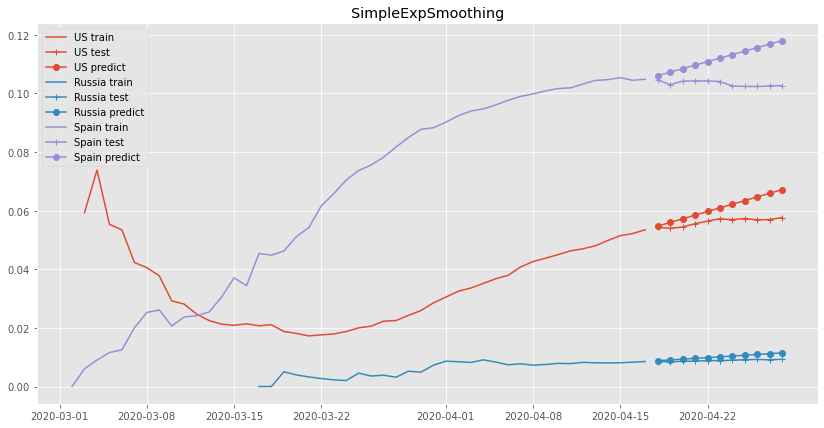

In [53]:
predict = test[['Date', 'n_day1', 'Country/Region', 'lag']].copy()
predict['lag_r'] = None

for country in tqdm(all_countries):
    model_linear = SimpleExpSmoothing(train[train['Country/Region'] == country].reset_index()['lag']).fit()
    index = predict['Country/Region'] == country
    predict.loc[index, 'lag_r'] = model_linear.forecast(sum(index)).values
predict = predict_to_normal(predict, train)
plot_predict(predict, 'SimpleExpSmoothing')
ex.add(predict, 'SimpleExpSmoothing')

In [54]:
from IPython.display import clear_output

World   US  Russia  Spain  Afghanistan  Algeria  \
const                 0.02 0.02    0.00   0.04         0.00     0.03   
const lag             0.01 0.00    0.00   0.02         0.00     0.03   
linear                0.01 0.02    0.00   0.01         0.02     0.08   
SimpleExpSmoothing    0.01 0.01    0.00   0.01         0.00     0.00   
Double ExpSmoothing   0.01 0.00    0.00   0.01         0.01     0.01   

                     Argentina  Armenia  Australia  Austria  ...  Slovenia  \
const                     0.02     0.01       0.00     0.02  ...      0.04   
const lag                 0.00     0.00       0.01     0.00  ...      0.00   
linear                    0.02     0.00       0.01     0.00  ...      0.01   
SimpleExpSmoothing        0.00     0.00       0.00     0.00  ...      0.00   
Double ExpSmoothing       0.00     0.00       0.00     0.00  ...      0.01   

                     South Africa  Sweden  Switzerland  Thailand  Turkey  \
const                        0.01    0.08         0.03      0.01    0.00   
const lag                    0.00    0.01         0.00      0.00    0.00   
linear                       0.01    0.02         0.01      0.01    0.00   
SimpleExpSmoothing           0.00    0.01         0.00      0.00    0.00   
Double ExpSmoothing          0.01    0.02         0.00      0.00    0.00   

                     Ukraine  United Arab Emirates  United Kingdom  Uzbekistan  
const                   0.00                  0.00            0.07        0.00  
const lag               0.00                  0.00            0.02        0.00  
linear                  0.00                  0.01            0.02        0.00  
SimpleExpSmoothing      0.00                  0.00            0.02        0.00  
Double ExpSmoothing     0.01                  0.00            0.00        0.00  

[5 rows x 87 columns]

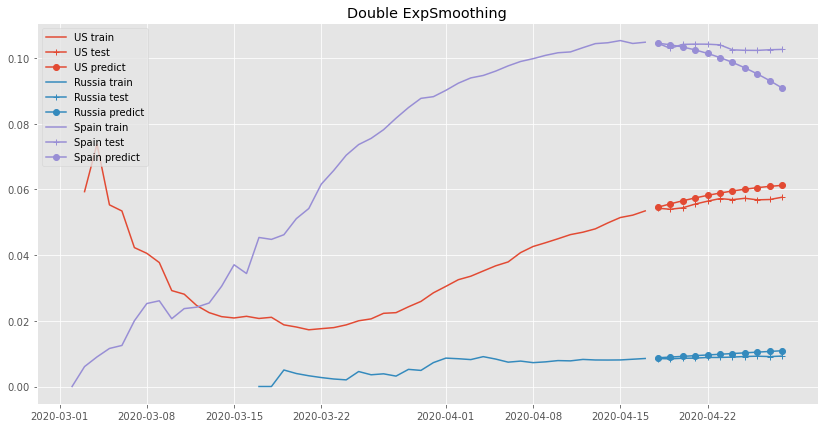

In [55]:
predict = test[['Date', 'n_day1', 'Country/Region', 'lag']].copy()
predict['lag_r'] = None

for country in tqdm(all_countries):
    model_linear = ExponentialSmoothing(train[train['Country/Region'] == country].reset_index()['lag'], trend='additive').fit()
    index = predict['Country/Region'] == country
    predict.loc[index, 'lag_r'] = model_linear.forecast(sum(index)).values
    clear_output()
predict = predict_to_normal(predict, train)
plot_predict(predict, 'Double ExpSmoothing')
ex.add(predict, 'Double ExpSmoothing')

#### 2.4 Скользящее среднее (MA - Moving average)

Поэксперементируйте с гиперпараметрами модели.

In [56]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



ARIMA(0, 0, 2) have 4 errors


C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\


ARIMA(0, 0, 3) have 5 errors


World   US  Russia  Spain  Afghanistan  Algeria  \
const                 0.02 0.02    0.00   0.04         0.00     0.03   
const lag             0.01 0.00    0.00   0.02         0.00     0.03   
linear                0.01 0.02    0.00   0.01         0.02     0.08   
SimpleExpSmoothing    0.01 0.01    0.00   0.01         0.00     0.00   
Double ExpSmoothing   0.01 0.00    0.00   0.01         0.01     0.01   
ARIMA(0, 0, 1)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 2)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 3)        0.01 0.00    0.00   0.02         0.00     0.02   

                     Argentina  Armenia  Australia  Austria  ...  Slovenia  \
const                     0.02     0.01       0.00     0.02  ...      0.04   
const lag                 0.00     0.00       0.01     0.00  ...      0.00   
linear                    0.02     0.00       0.01     0.00  ...      0.01   
SimpleExpSmoothing        0.00     0.00       0.00     0.00  ...      0.00   
Double ExpSmoothing       0.00     0.00       0.00     0.00  ...      0.01   
ARIMA(0, 0, 1)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(0, 0, 2)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(0, 0, 3)            0.00     0.00       0.00     0.00  ...      0.00   

                     South Africa  Sweden  Switzerland  Thailand  Turkey  \
const                        0.01    0.08         0.03      0.01    0.00   
const lag                    0.00    0.01         0.00      0.00    0.00   
linear                       0.01    0.02         0.01      0.01    0.00   
SimpleExpSmoothing           0.00    0.01         0.00      0.00    0.00   
Double ExpSmoothing          0.01    0.02         0.00      0.00    0.00   
ARIMA(0, 0, 1)               0.00    0.01         0.00      0.00    0.00   
ARIMA(0, 0, 2)               0.00    0.01         0.00      0.00    0.00   
ARIMA(0, 0, 3)               0.00    0.01         0.00      0.00    0.00   

                     Ukraine  United Arab Emirates  United Kingdom  Uzbekistan  
const                   0.00                  0.00            0.07        0.00  
const lag               0.00                  0.00            0.02        0.00  
linear                  0.00                  0.01            0.02        0.00  
SimpleExpSmoothing      0.00                  0.00            0.02        0.00  
Double ExpSmoothing     0.01                  0.00            0.00        0.00  
ARIMA(0, 0, 1)          0.00                  0.00            0.02        0.01  
ARIMA(0, 0, 2)          0.00                  0.00            0.02        0.01  
ARIMA(0, 0, 3)          0.00                  0.00            0.02        0.01  

[8 rows x 87 columns]

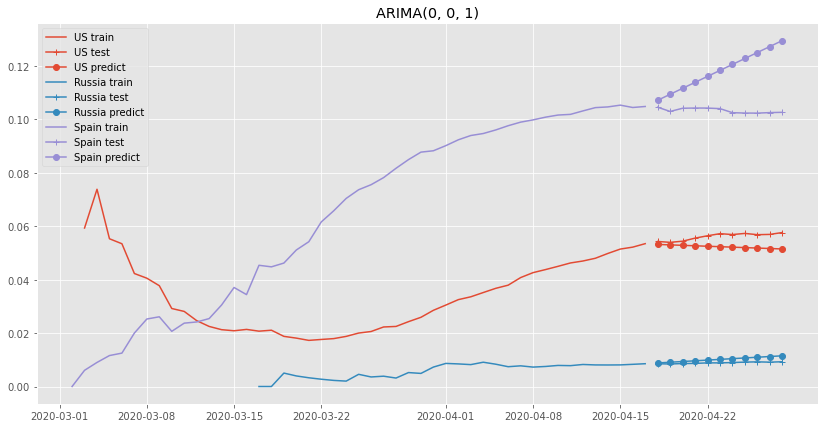

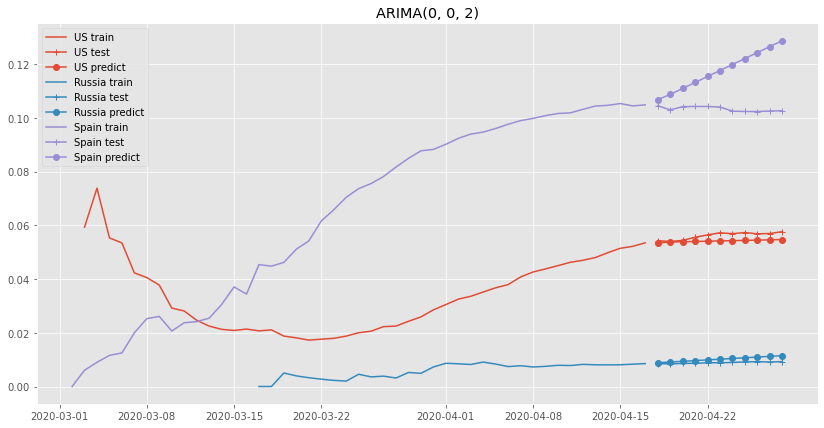

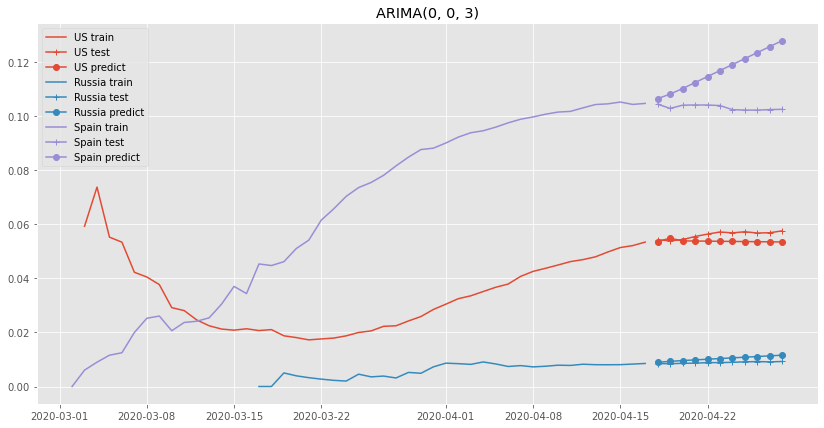

In [57]:
for param in range(1, 4):
    predict = test[['Date', 'n_day1', 'Country/Region', 'lag']].copy()
    predict['lag_r'] = np.nan

    bad = 0
    for country in tqdm(all_countries):
        try:
            _tr = train[train['Country/Region'] == country].reset_index()['lag']
            model = ARIMA(_tr, (0, 0, param))
            result = model.fit()

            index = predict['Country/Region'] == country
            predict.loc[index, 'lag_r'] = result.forecast(steps=sum(index))[0]
        except:
            bad += 1
    if bad:
        print(f'ARIMA(0, 0, {param}) have {bad} errors')
    predict = predict_to_normal(predict, train)
    plot_predict(predict, f'ARIMA(0, 0, {param})')
    ex.add(predict, f'ARIMA(0, 0, {param})');
ex.show

#### 2.5 Авторегрессионная модель (AR - Autoregressive model)

Поэксперементируйте с гиперпараметрами модели.

C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


World   US  Russia  Spain  Afghanistan  Algeria  \
const                 0.02 0.02    0.00   0.04         0.00     0.03   
const lag             0.01 0.00    0.00   0.02         0.00     0.03   
linear                0.01 0.02    0.00   0.01         0.02     0.08   
SimpleExpSmoothing    0.01 0.01    0.00   0.01         0.00     0.00   
Double ExpSmoothing   0.01 0.00    0.00   0.01         0.01     0.01   
ARIMA(0, 0, 1)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 2)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 3)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(1, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.01   
ARIMA(2, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.00   
ARIMA(3, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.00   

                     Argentina  Armenia  Australia  Austria  ...  Slovenia  \
const                     0.02     0.01       0.00     0.02  ...      0.04   
const lag                 0.00     0.00       0.01     0.00  ...      0.00   
linear                    0.02     0.00       0.01     0.00  ...      0.01   
SimpleExpSmoothing        0.00     0.00       0.00     0.00  ...      0.00   
Double ExpSmoothing       0.00     0.00       0.00     0.00  ...      0.01   
ARIMA(0, 0, 1)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(0, 0, 2)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(0, 0, 3)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(1, 0, 0)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(2, 0, 0)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(3, 0, 0)            0.00     0.00       0.00     0.00  ...      0.00   

                     South Africa  Sweden  Switzerland  Thailand  Turkey  \
const                        0.01    0.08         0.03      0.01    0.00   
const lag                    0.00    0.01         0.00      0.00    0.00   
linear                       0.01    0.02         0.01      0.01    0.00   
SimpleExpSmoothing           0.00    0.01         0.00      0.00    0.00   
Double ExpSmoothing          0.01    0.02         0.00      0.00    0.00   
ARIMA(0, 0, 1)               0.00    0.01         0.00      0.00    0.00   
ARIMA(0, 0, 2)               0.00    0.01         0.00      0.00    0.00   
ARIMA(0, 0, 3)               0.00    0.01         0.00      0.00    0.00   
ARIMA(1, 0, 0)               0.00    0.01         0.00      0.00    0.00   
ARIMA(2, 0, 0)               0.00    0.01         0.00      0.00    0.00   
ARIMA(3, 0, 0)               0.00    0.00         0.00      0.00    0.00   

                     Ukraine  United Arab Emirates  United Kingdom  Uzbekistan  
const                   0.00                  0.00            0.07        0.00  
const lag               0.00                  0.00            0.02        0.00  
linear                  0.00                  0.01            0.02        0.00  
SimpleExpSmoothing      0.00                  0.00            0.02        0.00  
Double ExpSmoothing     0.01                  0.00            0.00        0.00  
ARIMA(0, 0, 1)          0.00                  0.00            0.02        0.01  
ARIMA(0, 0, 2)          0.00                  0.00            0.02        0.01  
ARIMA(0, 0, 3)          0.00                  0.00            0.02        0.01  
ARIMA(1, 0, 0)          0.00                  0.00            0.02        0.01  
ARIMA(2, 0, 0)          0.00                  0.00            0.02        0.01  
ARIMA(3, 0, 0)          0.00                  0.00            0.02        0.01  

[11 rows x 87 columns]

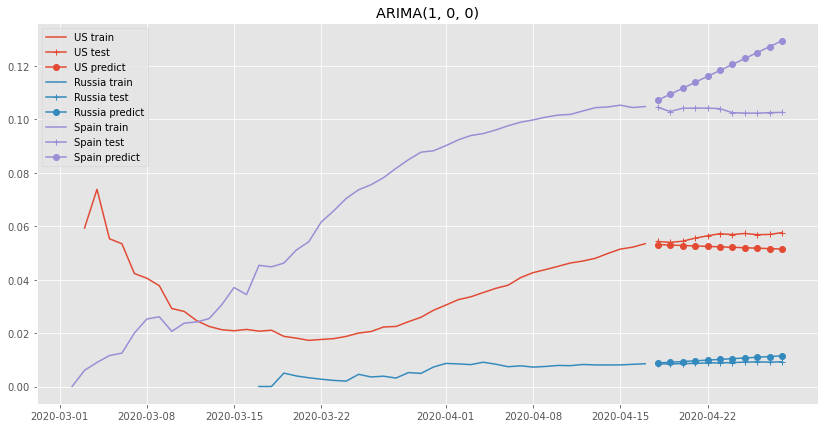

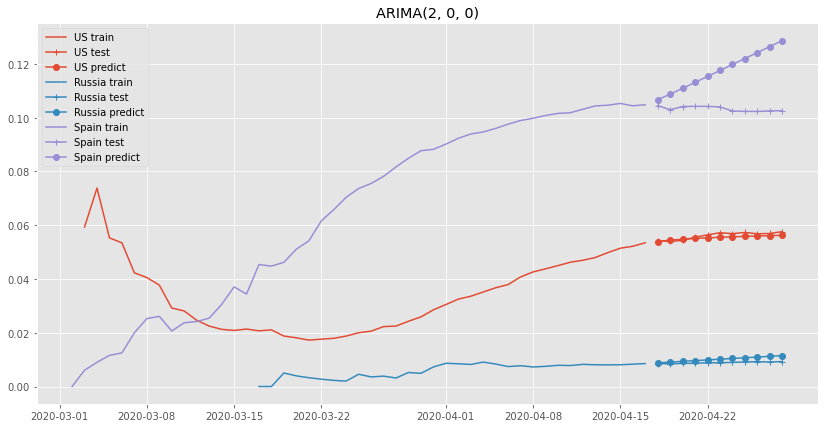

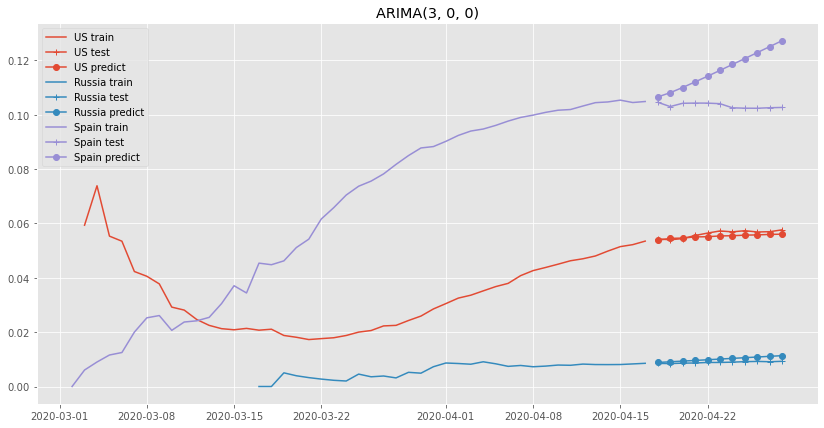

In [58]:
for param in range(1, 4):
    predict = test[['Date', 'n_day1', 'Country/Region', 'lag']].copy()
    predict['lag_r'] = np.nan

    bad = 0
    for country in tqdm(all_countries):
        try:
            _tr = train[train['Country/Region'] == country].reset_index()['lag']
            model = ARIMA(_tr, (param, 0, 0))
            result = model.fit()

            index = predict['Country/Region'] == country
            predict.loc[index, 'lag_r'] = result.forecast(steps=sum(index))[0]
        except:
            bad += 1
    if bad:
        print(f'ARIMA({param}, 0, 0) have {bad} errors')
    predict = predict_to_normal(predict, train)
    plot_predict(predict, f'ARIMA({param}, 0, 0)')
    ex.add(predict, f'ARIMA({param}, 0, 0)');
ex.show

#### 2.6 ARMA

Поэксперементируйте с гиперпараметрами модели.

C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning


ARIMA(1, 0, 1) have 33 errors


C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning


ARIMA(1, 0, 2) have 56 errors


C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



ARIMA(1, 0, 3) have 69 errors


C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\


ARIMA(2, 0, 1) have 3 errors


C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaco


ARIMA(2, 0, 2) have 29 errors


C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\


ARIMA(2, 0, 3) have 68 errors


C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\


ARIMA(3, 0, 1) have 3 errors


C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaco


ARIMA(3, 0, 2) have 9 errors


C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\


ARIMA(3, 0, 3) have 51 errors


World   US  Russia  Spain  Afghanistan  Algeria  \
const                 0.02 0.02    0.00   0.04         0.00     0.03   
const lag             0.01 0.00    0.00   0.02         0.00     0.03   
linear                0.01 0.02    0.00   0.01         0.02     0.08   
SimpleExpSmoothing    0.01 0.01    0.00   0.01         0.00     0.00   
Double ExpSmoothing   0.01 0.00    0.00   0.01         0.01     0.01   
ARIMA(0, 0, 1)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 2)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 3)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(1, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.01   
ARIMA(2, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.00   
ARIMA(3, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.00   
ARIMA(1, 0, 1)        0.00 0.00    0.00   0.02          nan     0.00   
ARIMA(1, 0, 2)        0.00 0.00     nan   0.02         0.00     0.00   
ARIMA(1, 0, 3)        0.00 0.01    0.00   0.02          nan     0.01   
ARIMA(2, 0, 1)        0.01 0.00    0.00   0.01         0.00     0.00   
ARIMA(2, 0, 2)        0.00 0.00    0.00   0.01         0.00     0.01   
ARIMA(2, 0, 3)        0.00  nan    0.00   0.02          nan      nan   
ARIMA(3, 0, 1)        0.01 0.01    0.00   0.01         0.00     0.00   
ARIMA(3, 0, 2)        0.01 0.01    0.00    nan         0.00     0.00   
ARIMA(3, 0, 3)        0.00  nan    0.00    nan         0.00     0.00   

                     Argentina  Armenia  Australia  Austria  ...  Slovenia  \
const                     0.02     0.01       0.00     0.02  ...      0.04   
const lag                 0.00     0.00       0.01     0.00  ...      0.00   
linear                    0.02     0.00       0.01     0.00  ...      0.01   
SimpleExpSmoothing        0.00     0.00       0.00     0.00  ...      0.00   
Double ExpSmoothing       0.00     0.00       0.00     0.00  ...      0.01   
ARIMA(0, 0, 1)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(0, 0, 2)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(0, 0, 3)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(1, 0, 0)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(2, 0, 0)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(3, 0, 0)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(1, 0, 1)             nan     0.00       0.01     0.00  ...       nan   
ARIMA(1, 0, 2)             nan     0.00       0.01      nan  ...      0.00   
ARIMA(1, 0, 3)             nan     0.00        nan      nan  ...       nan   
ARIMA(2, 0, 1)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(2, 0, 2)            0.00     0.00       0.01      nan  ...      0.00   
ARIMA(2, 0, 3)             nan     0.00        nan      nan  ...       nan   
ARIMA(3, 0, 1)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(3, 0, 2)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(3, 0, 3)             nan     0.00       0.01      nan  ...      0.00   

                     South Africa  Sweden  Switzerland  Thailand  Turkey  \
const                        0.01    0.08         0.03      0.01    0.00   
const lag                    0.00    0.01         0.00      0.00    0.00   
linear                       0.01    0.02         0.01      0.01    0.00   
SimpleExpSmoothing           0.00    0.01         0.00      0.00    0.00   
Double ExpSmoothing          0.01    0.02         0.00      0.00    0.00   
ARIMA(0, 0, 1)               0.00    0.01         0.00      0.00    0.00   
ARIMA(0, 0, 2)               0.00    0.01         0.00      0.00    0.00   
ARIMA(0, 0, 3)               0.00    0.01         0.00      0.00    0.00   
ARIMA(1, 0, 0)               0.00    0.01         0.00      0.00    0.00   
ARIMA(2, 0, 0)               0.00    0.01         0.00      0.00    0.00   
ARIMA(3, 0, 0)               0.00

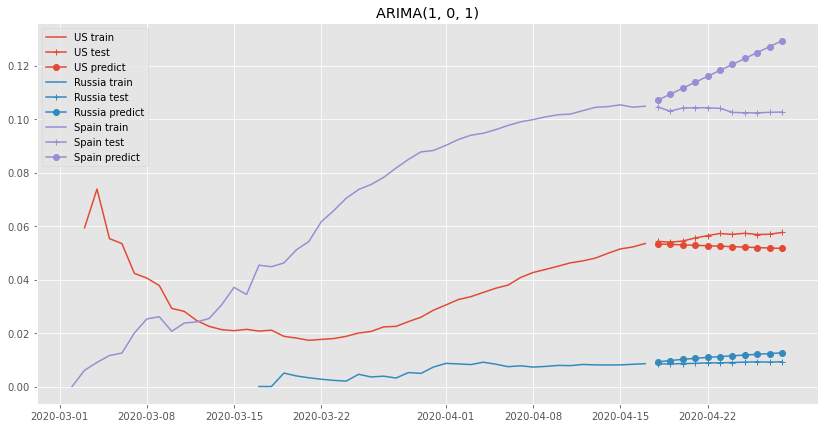

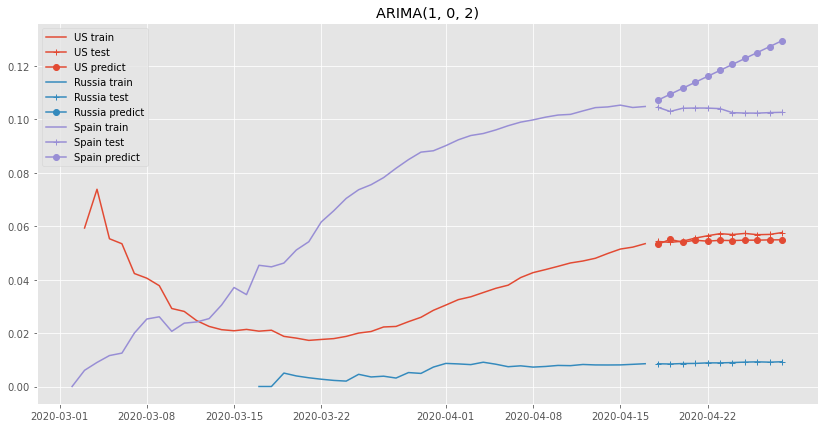

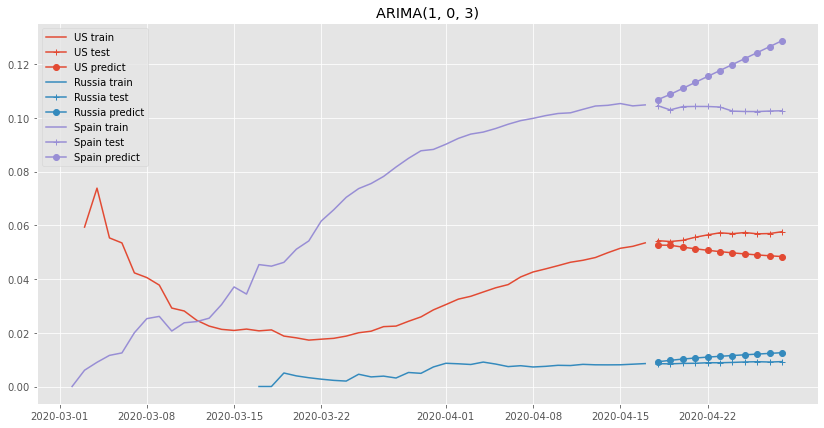

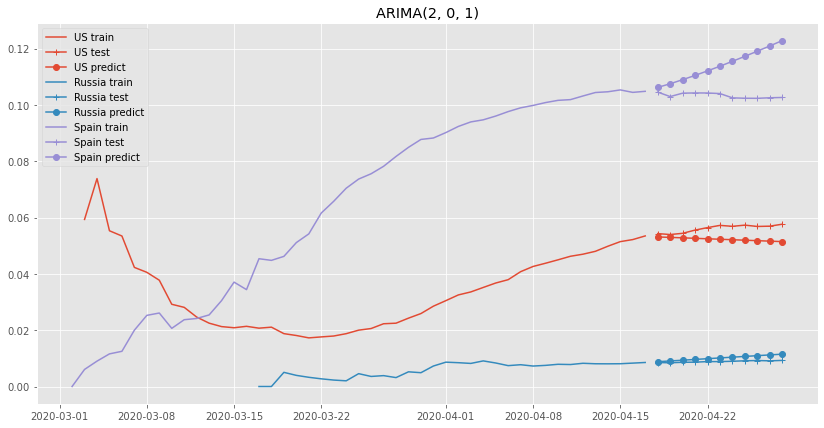

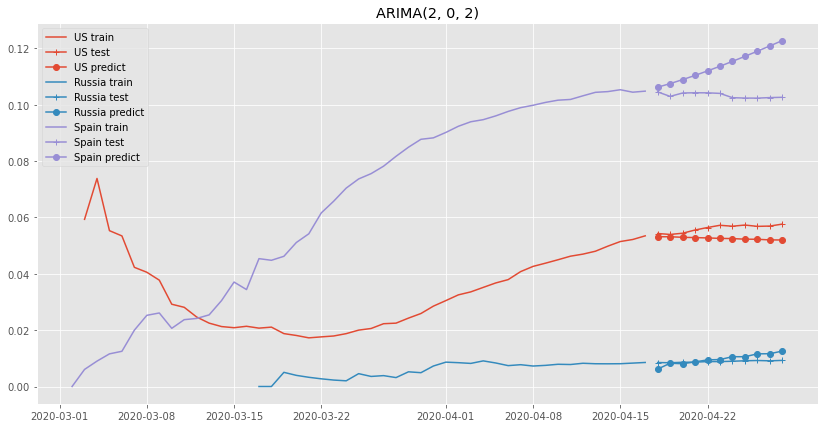

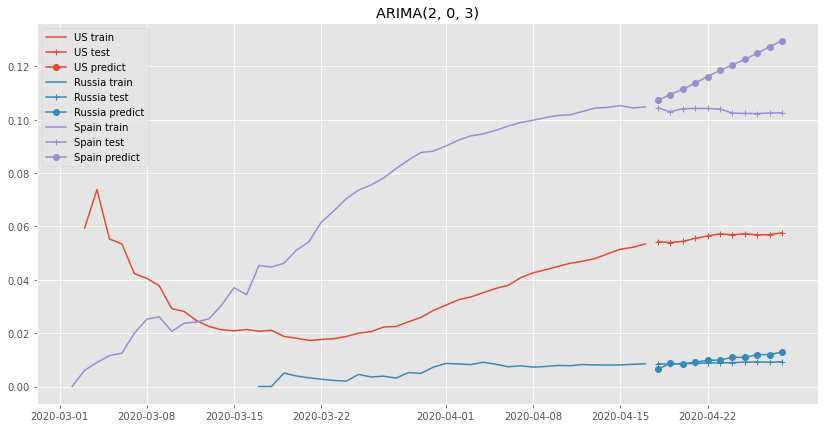

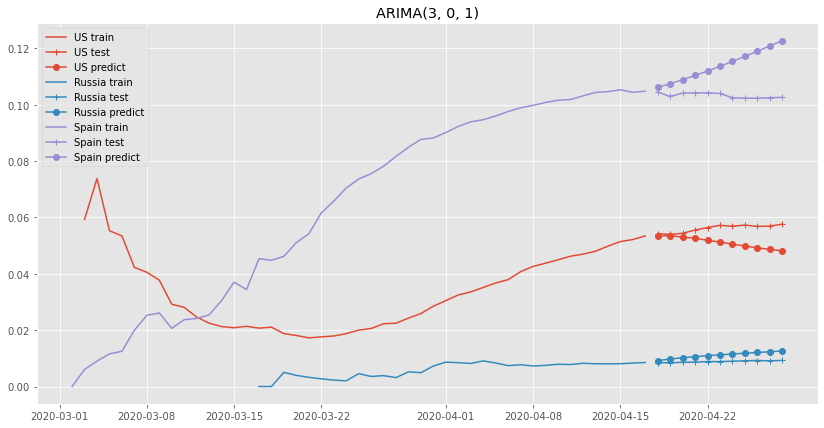

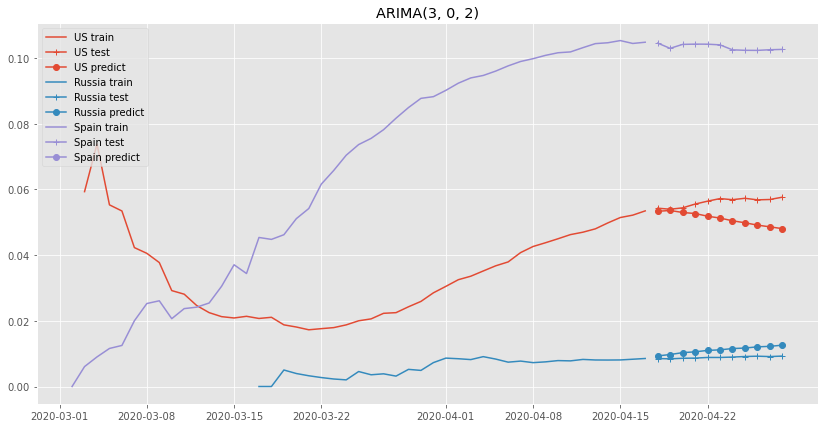

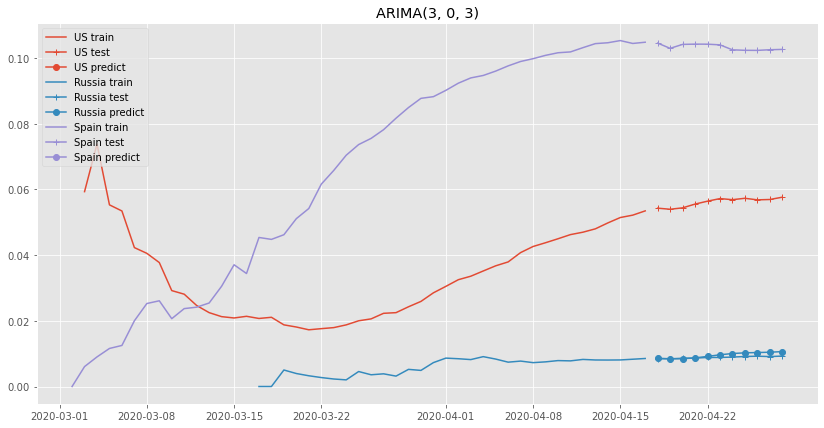

In [59]:
for _AR in range(1, 4):
    for _MA in range(1, 4):
        predict = test[['Date', 'n_day1', 'Country/Region', 'lag']].copy()
        predict['lag_r'] = np.nan

        bad = 0
        for country in tqdm(all_countries):
            try:
                _tr = train[train['Country/Region'] == country].reset_index()['lag']
                model = ARIMA(_tr, (_AR, 0, _MA))
                result = model.fit()

                index = predict['Country/Region'] == country
                predict.loc[index, 'lag_r'] = result.forecast(steps=sum(index))[0]
            except:
                bad += 1
        if bad:
            print(f'ARIMA({_AR}, 0, {_MA}) have {bad} errors')
        predict = predict_to_normal(predict, train)
        plot_predict(predict, f'ARIMA({_AR}, 0, {_MA})')
        ex.add(predict, f'ARIMA({_AR}, 0, {_MA})');
ex.show

#### 2.7 Интегрированная модель авторегрессии — скользящего среднего (Auto Regressive Integrated Moving Average)

C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



ARIMA(1, 1, 1) have 13 errors


C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



ARIMA(1, 2, 1) have 33 errors



ARIMA(1, 3, 1) have 86 errors


World   US  Russia  Spain  Afghanistan  Algeria  \
const                 0.02 0.02    0.00   0.04         0.00     0.03   
const lag             0.01 0.00    0.00   0.02         0.00     0.03   
linear                0.01 0.02    0.00   0.01         0.02     0.08   
SimpleExpSmoothing    0.01 0.01    0.00   0.01         0.00     0.00   
Double ExpSmoothing   0.01 0.00    0.00   0.01         0.01     0.01   
ARIMA(0, 0, 1)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 2)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 3)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(1, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.01   
ARIMA(2, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.00   
ARIMA(3, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.00   
ARIMA(1, 0, 1)        0.00 0.00    0.00   0.02          nan     0.00   
ARIMA(1, 0, 2)        0.00 0.00     nan   0.02         0.00     0.00   
ARIMA(1, 0, 3)        0.00 0.01    0.00   0.02          nan     0.01   
ARIMA(2, 0, 1)        0.01 0.00    0.00   0.01         0.00     0.00   
ARIMA(2, 0, 2)        0.00 0.00    0.00   0.01         0.00     0.01   
ARIMA(2, 0, 3)        0.00  nan    0.00   0.02          nan      nan   
ARIMA(3, 0, 1)        0.01 0.01    0.00   0.01         0.00     0.00   
ARIMA(3, 0, 2)        0.01 0.01    0.00    nan         0.00     0.00   
ARIMA(3, 0, 3)        0.00  nan    0.00    nan         0.00     0.00   
ARIMA(1, 1, 1)        0.01 0.02    0.00   0.00         0.02     0.02   
ARIMA(1, 2, 1)        0.03 0.02    0.00   0.01         0.01      nan   
ARIMA(1, 3, 1)        0.00  nan     nan    nan          nan      nan   

                     Argentina  Armenia  Australia  Austria  ...  Slovenia  \
const                     0.02     0.01       0.00     0.02  ...      0.04   
const lag                 0.00     0.00       0.01     0.00  ...      0.00   
linear                    0.02     0.00       0.01     0.00  ...      0.01   
SimpleExpSmoothing        0.00     0.00       0.00     0.00  ...      0.00   
Double ExpSmoothing       0.00     0.00       0.00     0.00  ...      0.01   
ARIMA(0, 0, 1)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(0, 0, 2)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(0, 0, 3)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(1, 0, 0)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(2, 0, 0)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(3, 0, 0)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(1, 0, 1)             nan     0.00       0.01     0.00  ...       nan   
ARIMA(1, 0, 2)             nan     0.00       0.01      nan  ...      0.00   
ARIMA(1, 0, 3)             nan     0.00        nan      nan  ...       nan   
ARIMA(2, 0, 1)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(2, 0, 2)            0.00     0.00       0.01      nan  ...      0.00   
ARIMA(2, 0, 3)             nan     0.00        nan      nan  ...       nan   
ARIMA(3, 0, 1)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(3, 0, 2)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(3, 0, 3)             nan     0.00       0.01      nan  ...      0.00   
ARIMA(1, 1, 1)            0.02      nan       0.01     0.00  ...      0.01   
ARIMA(1, 2, 1)            0.02      nan        nan     0.00  ...      0.00   
ARIMA(1, 3, 1)             nan      nan        nan      nan  ...       nan   

                     South Africa  Sweden  Switzerland  Thailand  Turkey  \
const                        0.01    0.08         0.03      0.01    0.00   
const lag                    0.00    0.01         0.00      0.00    0.00   
linear                       0.01    0.02         0.01      0.01    0.00   
SimpleExpSmoothing           0.00    0.01         0.00      0.00    0.00   
Double ExpSmoothing          0.01    0.

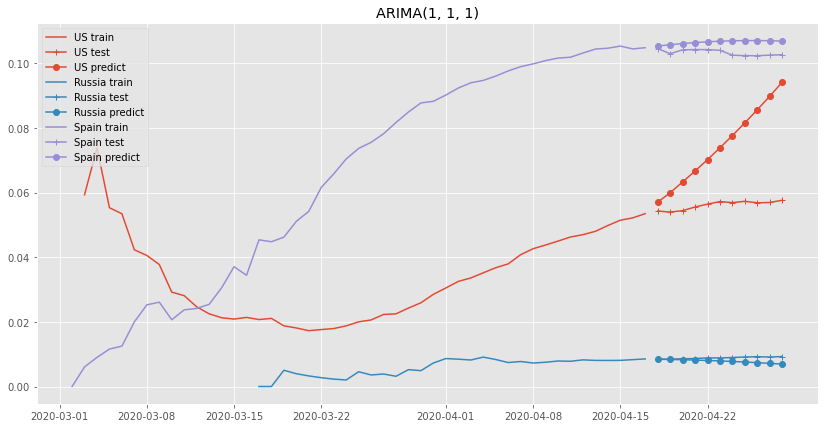

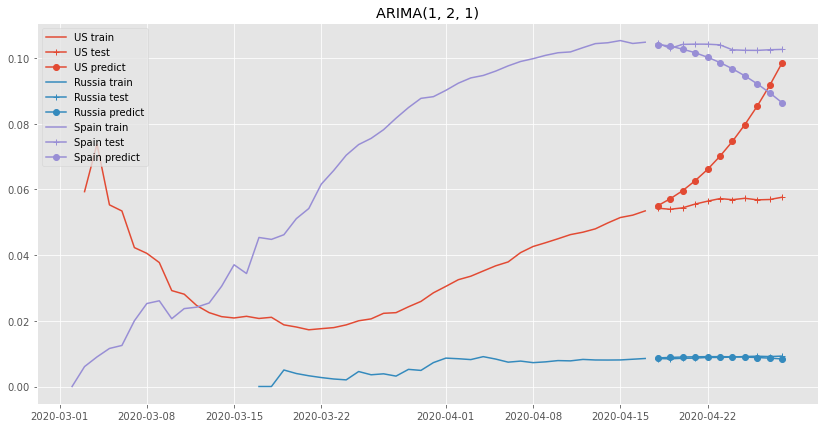

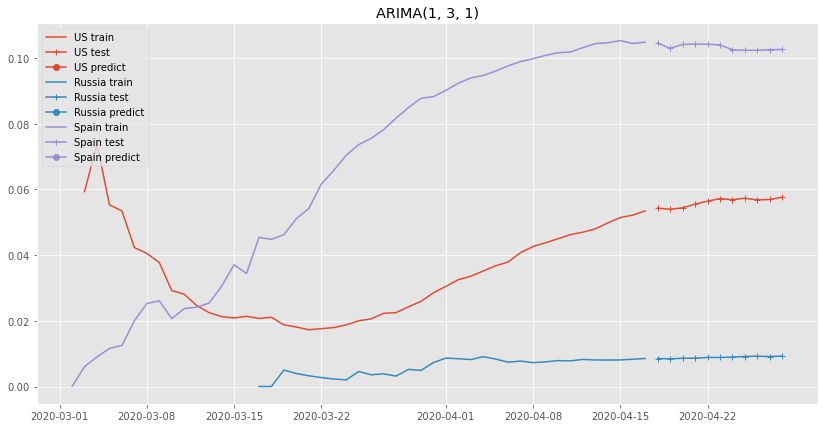

In [60]:
_AR = 1
_MA = 1

for _I in range(1, 4):
    predict = test[['Date', 'n_day1', 'Country/Region', 'lag']].copy()
    predict['lag_r'] = np.nan

    bad = 0
    for country in tqdm(all_countries):
        try:
            _tr = train[train['Country/Region'] == country].reset_index()['lag']
            model = ARIMA(_tr, (_AR, _I, _MA))
            result = model.fit()

            index = predict['Country/Region'] == country
            predict.loc[index, 'lag_r'] = result.forecast(steps=sum(index))[0]
        except:
            bad += 1
    if bad:
        print(f'ARIMA({_AR}, {_I}, {_MA}) have {bad} errors')
    predict = predict_to_normal(predict, train)
    plot_predict(predict, f'ARIMA({_AR}, {_I}, {_MA})')
    ex.add(predict, f'ARIMA({_AR}, {_I}, {_MA})');
ex.show

#### 2.8 SARIMA

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alex1\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check


SARIMAX(1, 1, 1) have 3 errors


World   US  Russia  Spain  Afghanistan  Algeria  \
const                 0.02 0.02    0.00   0.04         0.00     0.03   
const lag             0.01 0.00    0.00   0.02         0.00     0.03   
linear                0.01 0.02    0.00   0.01         0.02     0.08   
SimpleExpSmoothing    0.01 0.01    0.00   0.01         0.00     0.00   
Double ExpSmoothing   0.01 0.00    0.00   0.01         0.01     0.01   
ARIMA(0, 0, 1)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 2)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 3)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(1, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.01   
ARIMA(2, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.00   
ARIMA(3, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.00   
ARIMA(1, 0, 1)        0.00 0.00    0.00   0.02          nan     0.00   
ARIMA(1, 0, 2)        0.00 0.00     nan   0.02         0.00     0.00   
ARIMA(1, 0, 3)        0.00 0.01    0.00   0.02          nan     0.01   
ARIMA(2, 0, 1)        0.01 0.00    0.00   0.01         0.00     0.00   
ARIMA(2, 0, 2)        0.00 0.00    0.00   0.01         0.00     0.01   
ARIMA(2, 0, 3)        0.00  nan    0.00   0.02          nan      nan   
ARIMA(3, 0, 1)        0.01 0.01    0.00   0.01         0.00     0.00   
ARIMA(3, 0, 2)        0.01 0.01    0.00    nan         0.00     0.00   
ARIMA(3, 0, 3)        0.00  nan    0.00    nan         0.00     0.00   
ARIMA(1, 1, 1)        0.01 0.02    0.00   0.00         0.02     0.02   
ARIMA(1, 2, 1)        0.03 0.02    0.00   0.01         0.01      nan   
ARIMA(1, 3, 1)        0.00  nan     nan    nan          nan      nan   
SARIMAX(1, 1, 1)      0.02 0.00    0.00   0.00         0.00     0.00   

                     Argentina  Armenia  Australia  Austria  ...  Slovenia  \
const                     0.02     0.01       0.00     0.02  ...      0.04   
const lag                 0.00     0.00       0.01     0.00  ...      0.00   
linear                    0.02     0.00       0.01     0.00  ...      0.01   
SimpleExpSmoothing        0.00     0.00       0.00     0.00  ...      0.00   
Double ExpSmoothing       0.00     0.00       0.00     0.00  ...      0.01   
ARIMA(0, 0, 1)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(0, 0, 2)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(0, 0, 3)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(1, 0, 0)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(2, 0, 0)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(3, 0, 0)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(1, 0, 1)             nan     0.00       0.01     0.00  ...       nan   
ARIMA(1, 0, 2)             nan     0.00       0.01      nan  ...      0.00   
ARIMA(1, 0, 3)             nan     0.00        nan      nan  ...       nan   
ARIMA(2, 0, 1)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(2, 0, 2)            0.00     0.00       0.01      nan  ...      0.00   
ARIMA(2, 0, 3)             nan     0.00        nan      nan  ...       nan   
ARIMA(3, 0, 1)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(3, 0, 2)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(3, 0, 3)             nan     0.00       0.01      nan  ...      0.00   
ARIMA(1, 1, 1)            0.02      nan       0.01     0.00  ...      0.01   
ARIMA(1, 2, 1)            0.02      nan        nan     0.00  ...      0.00   
ARIMA(1, 3, 1)             nan      nan        nan      nan  ...       nan   
SARIMAX(1, 1, 1)          0.00     0.00       0.00     0.00  ...      0.00   

                     South Africa  Sweden  Switzerland  Thailand  Turkey  \
const                        0.01    0.08         0.03      0.01    0.00   
const lag                    0.00    0.01         0.00      0.00    0.00   
linear                       0.01    0.02

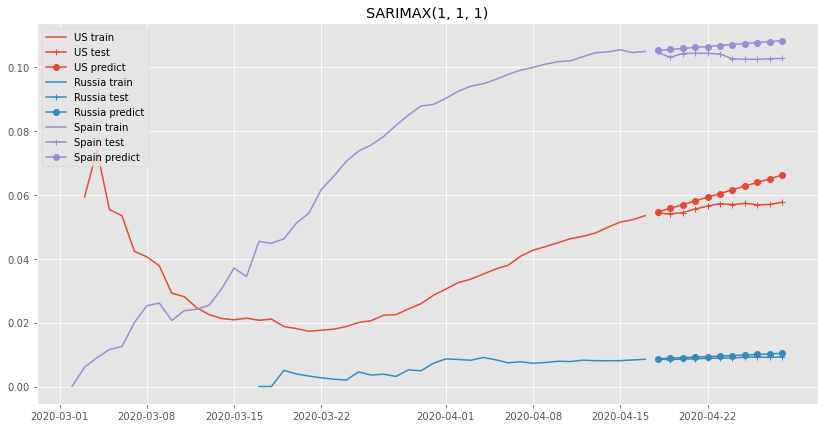

In [62]:
_AR = 1
_I = 1
_MA = 1

predict = test[['Date', 'n_day1', 'Country/Region', 'lag']].copy()
predict['lag_r'] = np.nan

bad = 0
for country in tqdm(all_countries):
    try:
        _tr = train[train['Country/Region'] == country].reset_index()['lag']
        model = SARIMAX(_tr, order=(_AR, _I, _MA))
        result = model.fit()

        index = predict['Country/Region'] == country
        predict.loc[index, 'lag_r'] = result.forecast(steps=sum(index)).values
    except:
        bad += 1
if bad:
    print(f'SARIMAX({_AR}, {_I}, {_MA}) have {bad} errors')
predict = predict_to_normal(predict, train)
plot_predict(predict, f'SARIMAX({_AR}, {_I}, {_MA})')
ex.add(predict, f'SARIMAX({_AR}, {_I}, {_MA})')

#### 2.9 Библиотека Prophet
Попробуйте использовать библиотеку Prophet для предсказания временного ряда. [Документация](https://facebook.github.io/prophet/docs/quick_start.html).


In [64]:
from fbprophet import Prophet

World   US  Russia  Spain  Afghanistan  Algeria  \
const                 0.02 0.02    0.00   0.04         0.00     0.03   
const lag             0.01 0.00    0.00   0.02         0.00     0.03   
linear                0.01 0.02    0.00   0.01         0.02     0.08   
SimpleExpSmoothing    0.01 0.01    0.00   0.01         0.00     0.00   
Double ExpSmoothing   0.01 0.00    0.00   0.01         0.01     0.01   
ARIMA(0, 0, 1)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 2)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 3)        0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(1, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.01   
ARIMA(2, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.00   
ARIMA(3, 0, 0)        0.01 0.00    0.00   0.02         0.00     0.00   
ARIMA(1, 0, 1)        0.00 0.00    0.00   0.02          nan     0.00   
ARIMA(1, 0, 2)        0.00 0.00     nan   0.02         0.00     0.00   
ARIMA(1, 0, 3)        0.00 0.01    0.00   0.02          nan     0.01   
ARIMA(2, 0, 1)        0.01 0.00    0.00   0.01         0.00     0.00   
ARIMA(2, 0, 2)        0.00 0.00    0.00   0.01         0.00     0.01   
ARIMA(2, 0, 3)        0.00  nan    0.00   0.02          nan      nan   
ARIMA(3, 0, 1)        0.01 0.01    0.00   0.01         0.00     0.00   
ARIMA(3, 0, 2)        0.01 0.01    0.00    nan         0.00     0.00   
ARIMA(3, 0, 3)        0.00  nan    0.00    nan         0.00     0.00   
ARIMA(1, 1, 1)        0.01 0.02    0.00   0.00         0.02     0.02   
ARIMA(1, 2, 1)        0.03 0.02    0.00   0.01         0.01      nan   
ARIMA(1, 3, 1)        0.00  nan     nan    nan          nan      nan   
SARIMAX(1, 1, 1)      0.02 0.00    0.00   0.00         0.00     0.00   
Phrofet               0.01 0.02    0.00   0.01         0.02     0.08   

                     Argentina  Armenia  Australia  Austria  ...  Slovenia  \
const                     0.02     0.01       0.00     0.02  ...      0.04   
const lag                 0.00     0.00       0.01     0.00  ...      0.00   
linear                    0.02     0.00       0.01     0.00  ...      0.01   
SimpleExpSmoothing        0.00     0.00       0.00     0.00  ...      0.00   
Double ExpSmoothing       0.00     0.00       0.00     0.00  ...      0.01   
ARIMA(0, 0, 1)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(0, 0, 2)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(0, 0, 3)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(1, 0, 0)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(2, 0, 0)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(3, 0, 0)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(1, 0, 1)             nan     0.00       0.01     0.00  ...       nan   
ARIMA(1, 0, 2)             nan     0.00       0.01      nan  ...      0.00   
ARIMA(1, 0, 3)             nan     0.00        nan      nan  ...       nan   
ARIMA(2, 0, 1)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(2, 0, 2)            0.00     0.00       0.01      nan  ...      0.00   
ARIMA(2, 0, 3)             nan     0.00        nan      nan  ...       nan   
ARIMA(3, 0, 1)            0.00     0.00       0.00     0.00  ...      0.00   
ARIMA(3, 0, 2)            0.00     0.00       0.01     0.00  ...      0.00   
ARIMA(3, 0, 3)             nan     0.00       0.01      nan  ...      0.00   
ARIMA(1, 1, 1)            0.02      nan       0.01     0.00  ...      0.01   
ARIMA(1, 2, 1)            0.02      nan        nan     0.00  ...      0.00   
ARIMA(1, 3, 1)             nan      nan        nan      nan  ...       nan   
SARIMAX(1, 1, 1)          0.00     0.00       0.00     0.00  ...      0.00   
Phrofet                   0.01     0.00       0.01     0.00  ...      0.01   

                     South Africa  Sweden  Switzerland  Thailand  Turkey  \
const                        0.01    0.08  

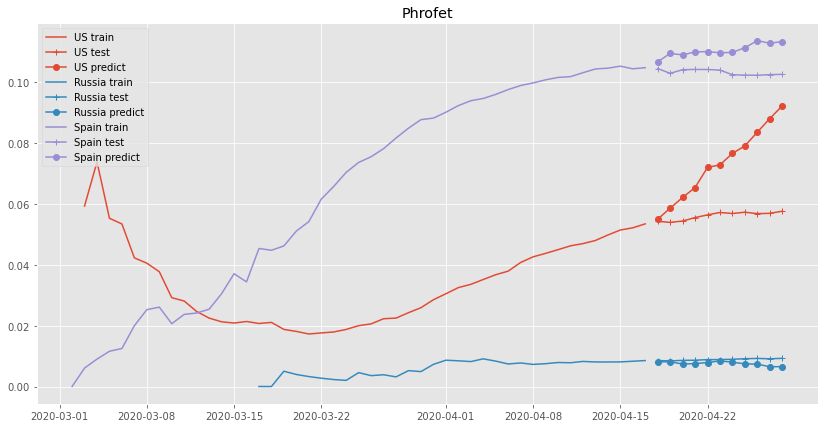

In [81]:
predict = test[['Date', 'n_day1', 'Country/Region', 'lag']].copy()
predict['lag_r'] = np.nan

for country in tqdm(all_countries):
    _tr = train[train['Country/Region'] == country].reset_index()[['Date', 'lag']]
    _tr.columns = ['ds', 'y']
    model = Prophet(weekly_seasonality=True)
    result = model.fit(_tr)

    index = predict['Country/Region'] == country
    predict.loc[index, 'lag_r'] = model.predict(model.make_future_dataframe(periods=sum(index)))['yhat'][-sum(index):].values
clear_output()
predict = predict_to_normal(predict, train)
plot_predict(predict, f'Phrofet')
ex.add(predict, f'Phrofet')

#### 2.10 Линейная модель с регрессией (Linear Regression Model)

Какие признаки оказались наиболее значимыми?

World   US  Russia  Spain  Afghanistan  Algeria  \
const                          0.02 0.02    0.00   0.04         0.00     0.03   
const lag                      0.01 0.00    0.00   0.02         0.00     0.03   
linear                         0.01 0.02    0.00   0.01         0.02     0.08   
SimpleExpSmoothing             0.01 0.01    0.00   0.01         0.00     0.00   
Double ExpSmoothing            0.01 0.00    0.00   0.01         0.01     0.01   
ARIMA(0, 0, 1)                 0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 2)                 0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 3)                 0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(1, 0, 0)                 0.01 0.00    0.00   0.02         0.00     0.01   
ARIMA(2, 0, 0)                 0.01 0.00    0.00   0.02         0.00     0.00   
ARIMA(3, 0, 0)                 0.01 0.00    0.00   0.02         0.00     0.00   
ARIMA(1, 0, 1)                 0.00 0.00    0.00   0.02          nan     0.00   
ARIMA(1, 0, 2)                 0.00 0.00     nan   0.02         0.00     0.00   
ARIMA(1, 0, 3)                 0.00 0.01    0.00   0.02          nan     0.01   
ARIMA(2, 0, 1)                 0.01 0.00    0.00   0.01         0.00     0.00   
ARIMA(2, 0, 2)                 0.00 0.00    0.00   0.01         0.00     0.01   
ARIMA(2, 0, 3)                 0.00  nan    0.00   0.02          nan      nan   
ARIMA(3, 0, 1)                 0.01 0.01    0.00   0.01         0.00     0.00   
ARIMA(3, 0, 2)                 0.01 0.01    0.00    nan         0.00     0.00   
ARIMA(3, 0, 3)                 0.00  nan    0.00    nan         0.00     0.00   
ARIMA(1, 1, 1)                 0.01 0.02    0.00   0.00         0.02     0.02   
ARIMA(1, 2, 1)                 0.03 0.02    0.00   0.01         0.01      nan   
ARIMA(1, 3, 1)                 0.00  nan     nan    nan          nan      nan   
SARIMAX(1, 1, 1)               0.02 0.00    0.00   0.00         0.00     0.00   
Phrofet                        0.01 0.02    0.00   0.01         0.02     0.08   
Линейная модель с регрессией   0.01 0.02    0.00   0.01         0.02     0.08   

                              Argentina  Armenia  Australia  Austria  ...  \
const                              0.02     0.01       0.00     0.02  ...   
const lag                          0.00     0.00       0.01     0.00  ...   
linear                             0.02     0.00       0.01     0.00  ...   
SimpleExpSmoothing                 0.00     0.00       0.00     0.00  ...   
Double ExpSmoothing                0.00     0.00       0.00     0.00  ...   
ARIMA(0, 0, 1)                     0.00     0.00       0.01     0.00  ...   
ARIMA(0, 0, 2)                     0.00     0.00       0.01     0.00  ...   
ARIMA(0, 0, 3)                     0.00     0.00       0.00     0.00  ...   
ARIMA(1, 0, 0)                     0.00     0.00       0.01     0.00  ...   
ARIMA(2, 0, 0)                     0.00     0.00       0.00     0.00  ...   
ARIMA(3, 0, 0)                     0.00     0.00       0.00     0.00  ...   
ARIMA(1, 0, 1)                      nan     0.00       0.01     0.00  ...   
ARIMA(1, 0, 2)                      nan     0.00       0.01      nan  ...   
ARIMA(1, 0, 3)                      nan     0.00        nan      nan  ...   
ARIMA(2, 0, 1)                     0.00     0.00       0.01     0.00  ...   
ARIMA(2, 0, 2)                     0.00     0.00       0.01      nan  ...   
ARIMA(2, 0, 3)                      nan     0.00        nan      nan  ...   
ARIMA(3, 0, 1)                     0.00     0.00       0.00     0.00  ...   
ARIMA(3, 0, 2)                     0.00     0.00       0.01     0.00  ...   
ARIMA(3, 0, 3)                      nan     0.00       0.01      nan  ...   
ARIMA(1, 1, 1)                     0.02      nan       0.01     0.00  ...   
ARIMA(1, 2, 1)                     0.02      nan        nan     0.00  ...   
ARIMA(1, 3, 1)                      nan      nan        nan      nan  .

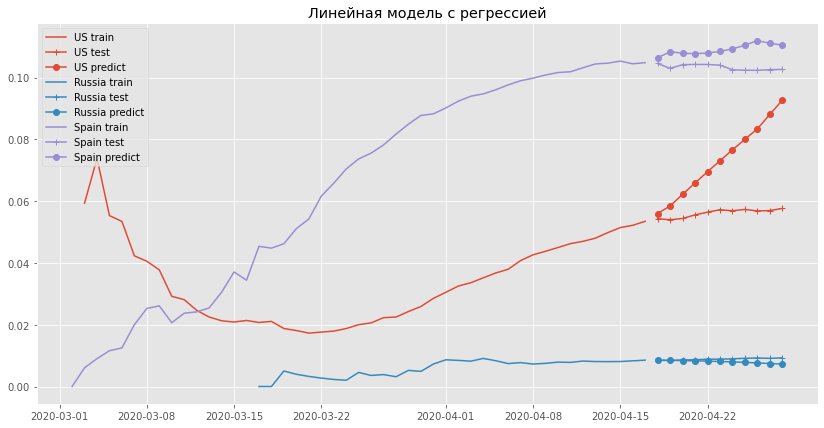

In [132]:
predict = test.copy()
predict['lag_r'] = None

for country in tqdm(all_countries):
    model_linear = smf.ols('lag ~ n_day1 + n_day100 + n_day1000 + day_of_week', data=train[train['Country/Region'] == country]).fit()
    index = predict['Country/Region'] == country
    predict.loc[index, 'lag_r'] = model_linear.predict(predict[index]) 
    if country == 'Russia':
        __res = model_linear.summary()
predict = predict_to_normal(predict, train)
plot_predict(predict, 'Линейная модель с регрессией')
ex.add(predict, 'Линейная модель с регрессией')

In [133]:
__res

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lag   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.050
Method:                 Least Squares   F-statistic:                    0.2669
Date:                Mon, 04 May 2020   Prob (F-statistic):              0.768
Time:                        20:23:00   Log-Likelihood:                 169.40
No. Observations:                  32   AIC:                            -332.8
Df Residuals:                      29   BIC:                            -328.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.381e-07   4.54e-07      0.966      0.342    -4.9e-07    1.37e-06
n_day1       8.651e-06   9.28e-06      0.933      0.359   -1.03e-05    2.76e-05
n_day100    -1.106e-05   1.29e-05     -0.855      0.400   -3.75e-05    1.54e-05
n_day1000   -1.545e-05   1.73e-05     -0.893      0.379   -5.08e-05    1.99e-05
day_of_week -2.809e-07      0.000     -0.002      0.998      -0.000       0.000
==============================================================================
Omnibus:                       23.431   Durbin-Watson:                   2.477
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.820
Skew:                           1.800   Prob(JB):                     6.13e-09
Kurtosis:                       6.925   Cond. No.                     7.41e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.38e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Наиболее значимые -- число дней после 100 и 1000 заражения, то есть когда ситуация по динамике стабилизировалась.

2.11 (Бонус) Используйте любую другую известную вам модель для предсказания.

In [135]:
from catboost import CatBoostRegressor

In [185]:
def df2normal(df, delay=7, col='lag', for_date=None):
    df = df.sort_values('Date').groupby('Country/Region').agg(lambda x: list(x))
    delay = datetime.timedelta(delay)

    result = []
    for country, __df in tqdm(df.iterrows(), total=len(df)):
        for l_date, l_nday1, l_nday100, l_nday1000, l_lag in zip(__df['Date'], __df['n_day1'], __df['n_day100'], __df['n_day1000'], __df[col]):
            if for_date and for_date != l_date:
                continue
            row = {
                'date': (l_date - train['Date'].min()).days,
                'dayofweek': l_date.dayofweek,
                'n_day1': l_nday1,
                'n_day100': l_nday100,
                'n_day1000': l_nday1000,
                'lag': l_lag,
                'country': country,
            }
            for r_date, r_nday1, r_nday100, r_nday1000, r_lag in zip(__df['Date'], __df['n_day1'], __df['n_day100'], __df['n_day1000'], __df[col]):
                if l_date - delay <= r_date < l_date:
                    delta = (l_date - r_date).days
                    row[f'date_{delta}'] = (r_date - train['Date'].min()).days
                    row[f'dayofweek_{delta}'] = r_date.dayofweek
                    row[f'n_day1_{delta}'] = r_nday1
                    row[f'n_day100_{delta}'] = r_nday100
                    row[f'n_day1000_{delta}'] = r_nday1000
                    row[f'lag_{delta}'] = r_lag
            result.append(row)

    result = pd.DataFrame(result)
    return result

In [227]:
df3 = df2normal(__df, col='lag')
x_train = df3[df3['date'] < (split_date - train['Date'].min()).days].copy()
x_test = df3[df3['date'] >= (split_date - train['Date'].min()).days].copy()

y_train = x_train['lag']
y_test = x_test['lag']

x_train.drop(columns=['lag'], inplace=True)
x_test.drop(columns=['lag'], inplace=True)

In [228]:
clf_params = {
    'depth': 6,
    'num_trees': 10000,
    'random_strength': 3,
    'bagging_temperature': 1.02,
    'cat_features': ['country'],

    'eval_metric': 'RMSE',
    'random_seed': 42,
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 200,
    'task_type': 'CPU',
}

In [229]:
clf = CatBoostRegressor(**clf_params)
clf.fit(x_train, y_train, eval_set=(x_test, y_test), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [255]:
clf.get_feature_importance(prettified=True)

Feature Id  Importances
0       country        11.92
1         lag_1        10.84
2         lag_2         8.99
3         lag_3         4.73
4          date         3.93
5         lag_4         3.81
6         lag_5         3.77
7   dayofweek_3         3.47
8        n_day1         2.86
9     n_day1000         2.70
10       date_3         2.05
11        lag_6         2.00
12       date_1         1.91
13     n_day1_4         1.88
14        lag_7         1.86
15  dayofweek_4         1.74
16       date_2         1.56
17       date_4         1.51
18  dayofweek_1         1.48
19  dayofweek_5         1.46
20       date_7         1.43
21  dayofweek_2         1.41
22    dayofweek         1.41
23     n_day1_1         1.26
24     n_day1_7         1.21
25  dayofweek_6         1.20
26     n_day1_6         1.15
27     n_day1_2         1.12
28  n_day1000_7         1.10
29       date_6         1.08
30       date_5         1.07
31  n_day1000_2         1.05
32  n_day1000_1         1.03
33  n_day1000_3         1.01
34  dayofweek_7         0.96
35     n_day1_3         0.95
36  n_day1000_4         0.95
37   n_day100_5         0.70
38   n_day100_3         0.70
39     n_day100         0.64
40   n_day100_1         0.61
41   n_day100_2         0.61
42  n_day1000_6         0.58
43     n_day1_5         0.51
44   n_day100_4         0.49
45   n_day100_6         0.46
46  n_day1000_5         0.44
47   n_day100_7         0.40

In [230]:
df4 = __df.copy()
df4['lag'] = np.nan
for date in x_test['date'].unique():
    date = train['Date'].min() + datetime.timedelta(int(date))
    df4_ = df2normal(df4, col='lag', for_date=date)
    df4_.drop(columns='lag', inplace=True)
    df4.loc[df4['Date'] == date, 'lag'] = clf.predict(df4_)

World   US  Russia  Spain  Afghanistan  Algeria  \
const                          0.02 0.02    0.00   0.04         0.00     0.03   
const lag                      0.01 0.00    0.00   0.02         0.00     0.03   
linear                         0.01 0.02    0.00   0.01         0.02     0.08   
SimpleExpSmoothing             0.01 0.01    0.00   0.01         0.00     0.00   
Double ExpSmoothing            0.01 0.00    0.00   0.01         0.01     0.01   
ARIMA(0, 0, 1)                 0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 2)                 0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(0, 0, 3)                 0.01 0.00    0.00   0.02         0.00     0.02   
ARIMA(1, 0, 0)                 0.01 0.00    0.00   0.02         0.00     0.01   
ARIMA(2, 0, 0)                 0.01 0.00    0.00   0.02         0.00     0.00   
ARIMA(3, 0, 0)                 0.01 0.00    0.00   0.02         0.00     0.00   
ARIMA(1, 0, 1)                 0.00 0.00    0.00   0.02          nan     0.00   
ARIMA(1, 0, 2)                 0.00 0.00     nan   0.02         0.00     0.00   
ARIMA(1, 0, 3)                 0.00 0.01    0.00   0.02          nan     0.01   
ARIMA(2, 0, 1)                 0.01 0.00    0.00   0.01         0.00     0.00   
ARIMA(2, 0, 2)                 0.00 0.00    0.00   0.01         0.00     0.01   
ARIMA(2, 0, 3)                 0.00  nan    0.00   0.02          nan      nan   
ARIMA(3, 0, 1)                 0.01 0.01    0.00   0.01         0.00     0.00   
ARIMA(3, 0, 2)                 0.01 0.01    0.00    nan         0.00     0.00   
ARIMA(3, 0, 3)                 0.00  nan    0.00    nan         0.00     0.00   
ARIMA(1, 1, 1)                 0.01 0.02    0.00   0.00         0.02     0.02   
ARIMA(1, 2, 1)                 0.03 0.02    0.00   0.01         0.01      nan   
ARIMA(1, 3, 1)                 0.00  nan     nan    nan          nan      nan   
SARIMAX(1, 1, 1)               0.02 0.00    0.00   0.00         0.00     0.00   
Phrofet                        0.01 0.02    0.00   0.01         0.02     0.08   
Линейная модель с регрессией   0.01 0.02    0.00   0.01         0.02     0.08   
Catboost                       0.00 0.00    0.00   0.00         0.00     0.02   

                              Argentina  Armenia  Australia  Austria  ...  \
const                              0.02     0.01       0.00     0.02  ...   
const lag                          0.00     0.00       0.01     0.00  ...   
linear                             0.02     0.00       0.01     0.00  ...   
SimpleExpSmoothing                 0.00     0.00       0.00     0.00  ...   
Double ExpSmoothing                0.00     0.00       0.00     0.00  ...   
ARIMA(0, 0, 1)                     0.00     0.00       0.01     0.00  ...   
ARIMA(0, 0, 2)                     0.00     0.00       0.01     0.00  ...   
ARIMA(0, 0, 3)                     0.00     0.00       0.00     0.00  ...   
ARIMA(1, 0, 0)                     0.00     0.00       0.01     0.00  ...   
ARIMA(2, 0, 0)                     0.00     0.00       0.00     0.00  ...   
ARIMA(3, 0, 0)                     0.00     0.00       0.00     0.00  ...   
ARIMA(1, 0, 1)                      nan     0.00       0.01     0.00  ...   
ARIMA(1, 0, 2)                      nan     0.00       0.01      nan  ...   
ARIMA(1, 0, 3)                      nan     0.00        nan      nan  ...   
ARIMA(2, 0, 1)                     0.00     0.00       0.01     0.00  ...   
ARIMA(2, 0, 2)                     0.00     0.00       0.01      nan  ...   
ARIMA(2, 0, 3)                      nan     0.00        nan      nan  ...   
ARIMA(3, 0, 1)                     0.00     0.00       0.00     0.00  ...   
ARIMA(3, 0, 2)                     0.00     0.00       0.01     0.00  ...   
ARIMA(3, 0, 3)                      nan     0.00       0.01      nan  ...   
ARIMA(1, 1, 1)                     0.02      nan       0.01     0.00  ...   
ARIMA(1, 2, 1)                     0.02      nan        nan     0.0

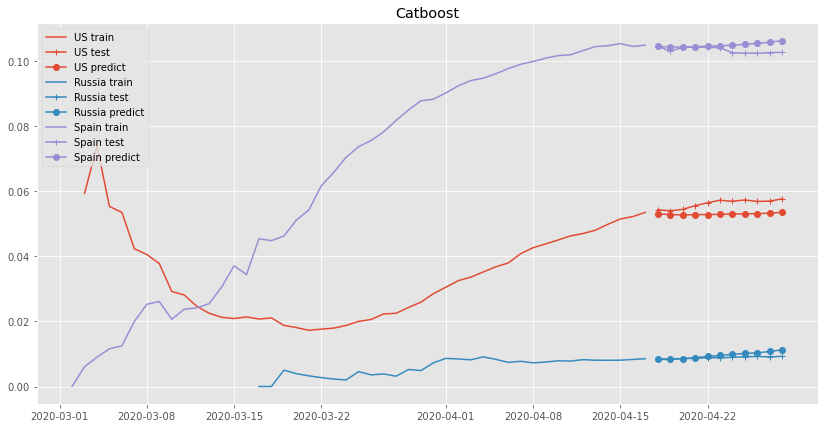

In [232]:
predict = test.copy()
predict['lag_r'] = df4[~df4['lag'].isna()]['lag']

predict = predict_to_normal(predict, train)
plot_predict(predict, 'Catboost')
ex.add(predict, 'Catboost')

#### 2.11 Выводы

In [234]:
ex.show.to_pickle('exp_results.pkl')

In [242]:
models = {k: 0 for k in ex.show.index}
top_models = {k: 0 for k in ex.show.index}

In [243]:
for col in ex.show.columns:
    for i, model in enumerate(ex.show.sort_values(col).index):
        if i == 0:
            top_models[model] += 1
        models[model] += i

Топ моделей по количеству первых мест:

In [250]:
pd.Series(top_models).sort_values(ascending=False)

Catboost                        15
SARIMAX(1, 1, 1)                14
SimpleExpSmoothing               8
ARIMA(2, 0, 0)                   5
linear                           4
Линейная модель с регрессией     4
ARIMA(3, 0, 2)                   4
ARIMA(1, 0, 1)                   3
Double ExpSmoothing              3
ARIMA(3, 0, 1)                   3
ARIMA(3, 0, 3)                   3
ARIMA(1, 1, 1)                   3
ARIMA(1, 2, 1)                   3
ARIMA(0, 0, 3)                   2
ARIMA(2, 0, 2)                   2
const lag                        2
Phrofet                          2
ARIMA(1, 0, 0)                   2
ARIMA(0, 0, 2)                   1
const                            1
ARIMA(3, 0, 0)                   1
ARIMA(2, 0, 3)                   1
ARIMA(1, 3, 1)                   1
ARIMA(0, 0, 1)                   0
ARIMA(1, 0, 2)                   0
ARIMA(2, 0, 1)                   0
ARIMA(1, 0, 3)                   0
dtype: int64

Рейтинг моделей по итоговой позиции:

In [252]:
pd.Series(models).sort_values(ascending=True)

Catboost                         643
SimpleExpSmoothing               670
SARIMAX(1, 1, 1)                 682
ARIMA(3, 0, 0)                   717
ARIMA(2, 0, 0)                   718
ARIMA(1, 0, 0)                   758
const lag                        815
ARIMA(3, 0, 1)                   872
ARIMA(2, 0, 1)                   888
ARIMA(0, 0, 1)                   895
ARIMA(0, 0, 2)                   908
ARIMA(0, 0, 3)                   928
ARIMA(3, 0, 2)                   974
Double ExpSmoothing             1016
Линейная модель с регрессией    1078
linear                          1088
ARIMA(1, 1, 1)                  1193
Phrofet                         1203
ARIMA(2, 0, 2)                  1210
ARIMA(1, 0, 1)                  1249
const                           1363
ARIMA(1, 0, 2)                  1552
ARIMA(3, 0, 3)                  1620
ARIMA(1, 2, 1)                  1659
ARIMA(1, 0, 3)                  1766
ARIMA(2, 0, 3)                  1839
ARIMA(1, 3, 1)                  2233
d

Как можно заметить, catboost победил все модели по качеству предсказания (выборка делилась по времени, данные для предсказания каждый раз обновлялись на основе предсказаний).

Тем не менее, некоторые алгоритмы близко подходят по качеству.
Возможно, catboost выиграл за счет обобщающей способности по всем странам, возможно ряд не совсем классический для задач временных рядов.

Кроме того можно провести дополнительные эксперименты по предсказанию для catboost на cfr, а не лаги; попробовать применить LSTM и другие RNN.

Тем не менее, для каждой задачи возможно лучше будет использовать свой алгоритм, который лучше всего описывает данный ряд. 